In [1]:
__depends__ = ["/Volumes/Seagate Expansion Drive/seq1_jcole_gene-editing_gene-editing_multiple/multiple"]
__dest__ = []

Summarize results from the gene editing scenarion in which the top 1% of bulls and no (0%) cows were edited for the horned locus.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.mpl_style = 'default'
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import seaborn as sns

/home/jcole/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jcole/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
print pd.__version__

0.18.0


In [4]:
plt.rcdefaults()
# Typeface sizes
from matplotlib import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
#rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Computer Modern Roman']
#rcParams['text.usetex'] = True

# Optimal figure size
WIDTH = 350.0  # the number latex spits out
FACTOR = 0.90  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims      = [fig_width_in, fig_height_in] # fig dims as a list

rcParams['figure.figsize'] = fig_dims

In [5]:
methods = ['noedits', 'zfn', 'talen', 'crispr', 'perfect']
for method in methods:
    # We have 10 relicates for each simulation
    for sim in xrange(1,11):
        # Load the individual allele frequency history files
        af = pd.read_csv('multiple/01_00/%s/%s/minor_allele_frequencies_%s.txt'%(method,sim, method), sep='\t')
        af.columns = ['generation', 'Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM', 'DUMPS',
                     'Mulefoot', 'Horned', 'Red']
        af['replicate'] = sim
        af['method'] = method
        if sim == 1 and method == methods[0]:
            all_replicates = af
        else:
            all_replicates = pd.concat([all_replicates, af])

In [6]:
all_replicates.head()

generation  Brachyspina       HH1       HH2       HH3       HH4       HH5  \
0           1     0.039109  0.017790  0.031511  0.038409  0.011951  0.028502   
1           2     0.038041  0.016184  0.027571  0.039207  0.010664  0.027710   
2           3     0.035770  0.013180  0.037404  0.043887  0.009311  0.027565   
3           4     0.040557  0.014562  0.039229  0.042766  0.012502  0.027473   
4           5     0.042080  0.011816  0.041035  0.041896  0.011050  0.039726   

       BLAD       CVM     DUMPS  Mulefoot    Horned       Red  replicate  \
0  0.007286  0.025701  0.002167  0.000454  0.994067  0.054505          1   
1  0.006513  0.027841  0.002007  0.000368  0.994702  0.051823          1   
2  0.006289  0.035641  0.001763  0.000279  0.995808  0.052894          1   
3  0.005403  0.046637  0.001592  0.000204  0.996632  0.048896          1   
4  0.004677  0.041368  0.001448  0.000169  0.997164  0.050259          1   

    method  
0  noedits  
1  noedits  
2  noedits  
3  noedits  
4  noedits

In [7]:
all_replicates = pd.melt(all_replicates,
                         id_vars = ['generation', 'replicate', 'method'],
                         value_vars = ['Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM',
                                       'DUMPS', 'Mulefoot', 'Horned', 'Red'],
                        var_name = 'recessive',
                        value_name = 'frequency')

In [8]:
all_replicates.head()

generation  replicate   method    recessive  frequency
0           1          1  noedits  Brachyspina   0.039109
1           2          1  noedits  Brachyspina   0.038041
2           3          1  noedits  Brachyspina   0.035770
3           4          1  noedits  Brachyspina   0.040557
4           5          1  noedits  Brachyspina   0.042080

In [9]:
grouped = all_replicates.groupby(['generation', 'method', 'recessive']).mean().reset_index()
grouped.head()

generation  method    recessive  replicate  frequency
0           1  crispr         BLAD        5.5   0.005182
1           1  crispr  Brachyspina        5.5   0.031392
2           1  crispr          CVM        5.5   0.018392
3           1  crispr        DUMPS        5.5   0.004156
4           1  crispr          HH1        5.5   0.029887

In [10]:
expected = {}
actual = {}

for r in ['Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM', 'DUMPS', 'Mulefoot', 'Horned', 'Red']:
    expected[r] = {}
    actual[r] = {}
    for method in methods:
        expected[r][method] = []
        actual[r][method] = []
        # Red and horned are NOT lethals
        if r in ['Horned', 'Red']:
            for g in xrange(1,21):
                if g == 1:
                    expected[r][method].append(float(grouped[(grouped['generation']==g) & 
                                                             (grouped['method']==method) &
                                                             (grouped['recessive']==r)]
                                                     ['frequency']))
                else:
                    q0 = expected[r][method][g-2]
                    p0 = 1. - q0
                    q1 = (p0*q0) + q0**2
                    #print 'g: ', g, ', q0: ', q0, ', p0: ', p0, ', q1: ', q1
                    expected[r][method].append(q1)
                actual[r][method].append(float(grouped[(grouped['generation']==g) &
                                                 (grouped['method']==method) &
                                                 (grouped['recessive']==r)]
                                               ['frequency']))

        # The other recessives are lethals        
        else:
            for g in xrange(1,21):
                if g == 1:
                    expected[r][method].append(float(grouped[(grouped['generation']==g) & 
                                                             (grouped['method']==method) &
                                                             (grouped['recessive']==r)]
                                                     ['frequency']))
                else:
                    q0 = expected[r][method][g-2]
                    p0 = 1. - q0
                    q1 = (p0*q0) / (p0**2 + (2*p0*q0))
                    #print 'g: ', g, ', q0: ', q0, ', p0: ', p0, ', q1: ', q1
                    expected[r][method].append(q1)
                actual[r][method].append(float(grouped[(grouped['generation']==g) &
                                                 (grouped['method']==method) &
                                                 (grouped['recessive']==r)]
                                               ['frequency']))
#for k in expected[r].keys():
#print k, ':\t', expected[r][k], '\n'
    
print expected['HH1']['talen']
print
print actual['HH1']['talen']

[0.027490713813719998, 0.026755194420865543, 0.026058007367527013, 0.02539623216272334, 0.024767237645450146, 0.02416864702110933, 0.023598307848425266, 0.023054266177938734, 0.022534744187195373, 0.022038120773204686, 0.021562914655797905, 0.021107769620888443, 0.020671441593990834, 0.02025278728452329, 0.019850754182625222, 0.01946437172420871, 0.01909274346811045, 0.01873504015261188, 0.018390493518123486, 0.018058390799183366]

[0.027490713813719998, 0.02669562657415, 0.027029853430849998, 0.025742786069650997, 0.025734825870642, 0.025789552238793995, 0.024206965174117002, 0.024184577114427, 0.022635820895525998, 0.022816915422893002, 0.020636815920396002, 0.020846766169141, 0.019438308457701, 0.0191955223880707, 0.0204238805970171, 0.0188238805970207, 0.0181014925373148, 0.0170199004975163, 0.0162691542288466, 0.0153174129353218]


Brachyspina


/home/jcole/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


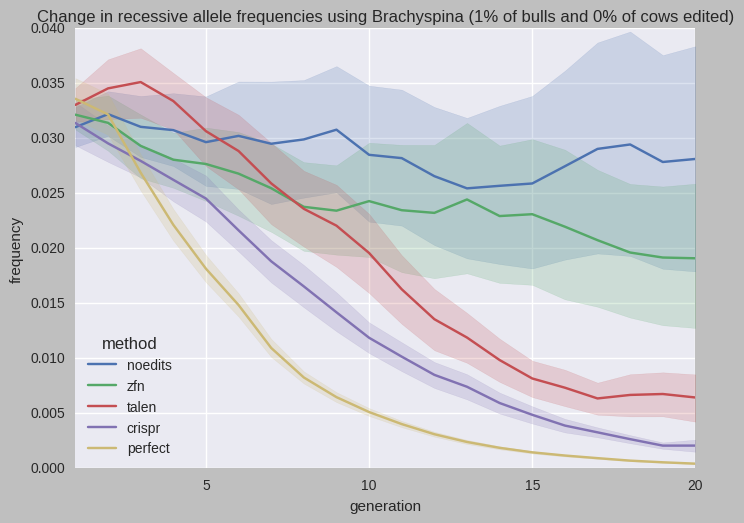

HH1


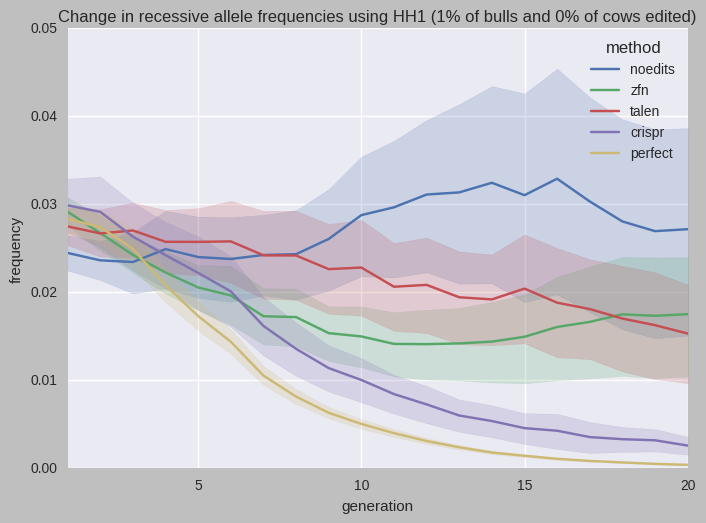

HH2


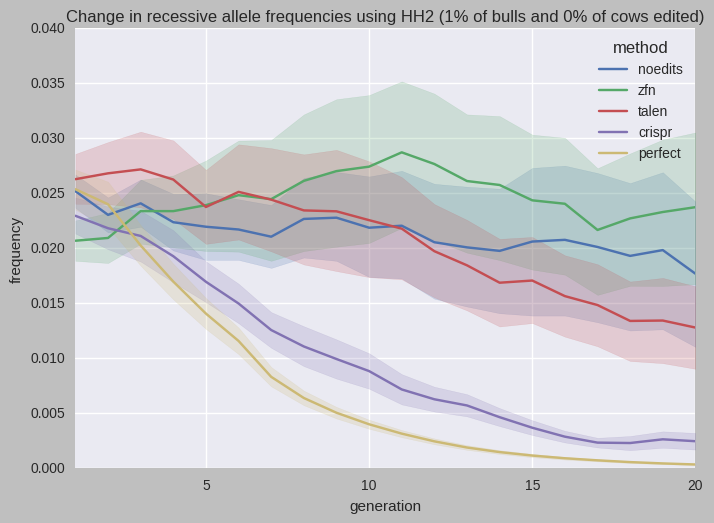

HH3


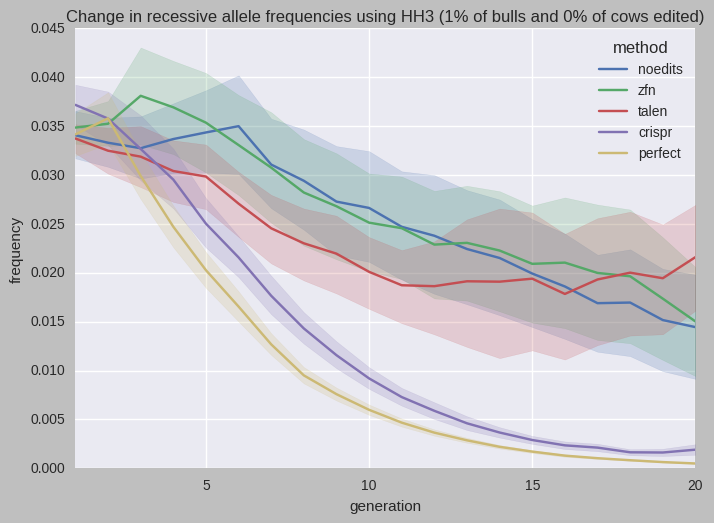

HH4


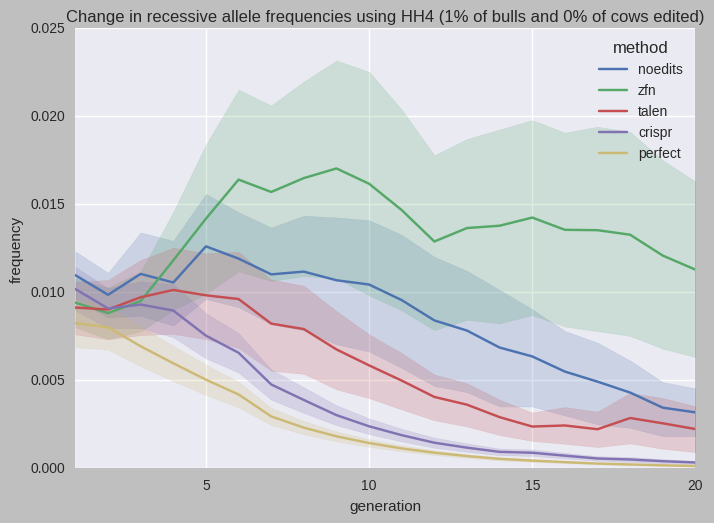

HH5


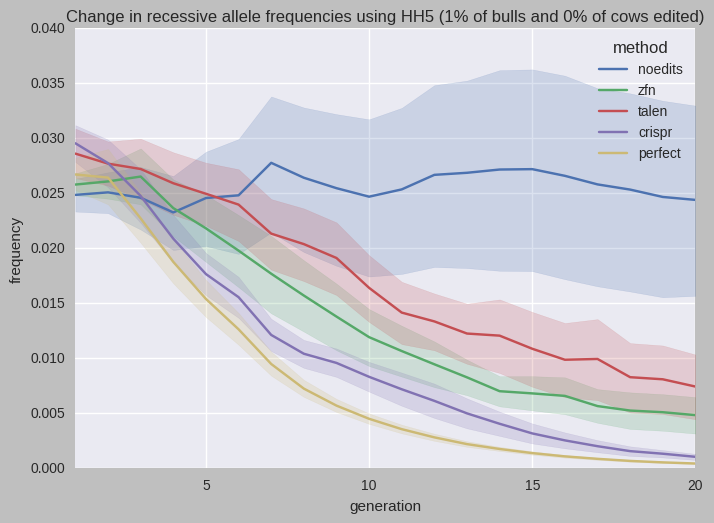

BLAD


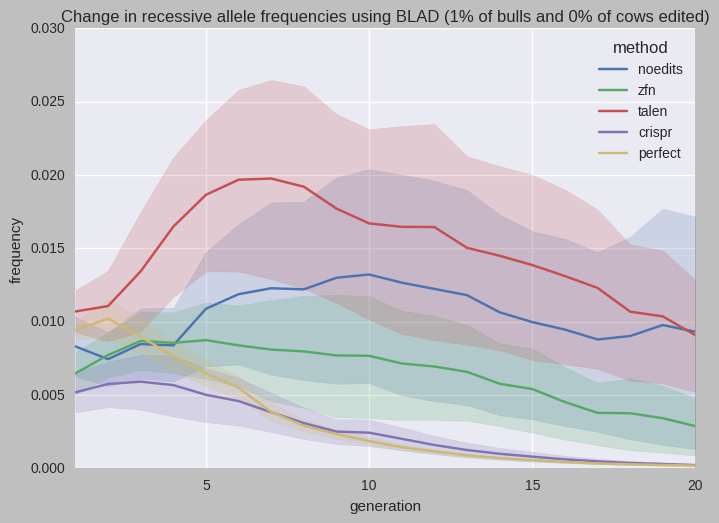

CVM


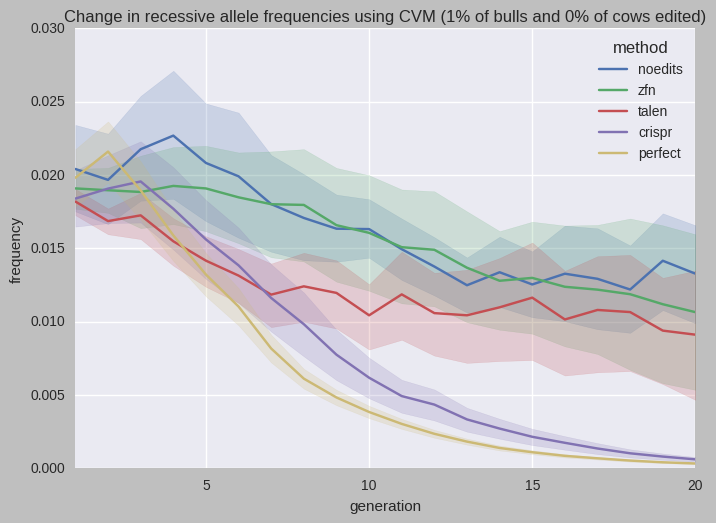

DUMPS


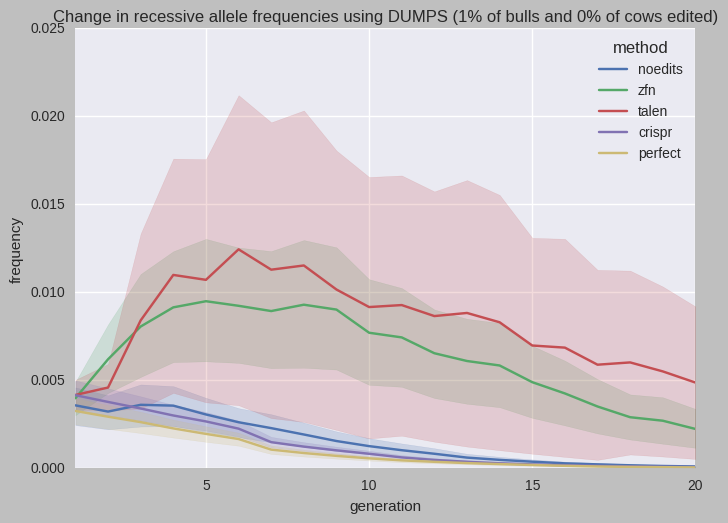

Mulefoot


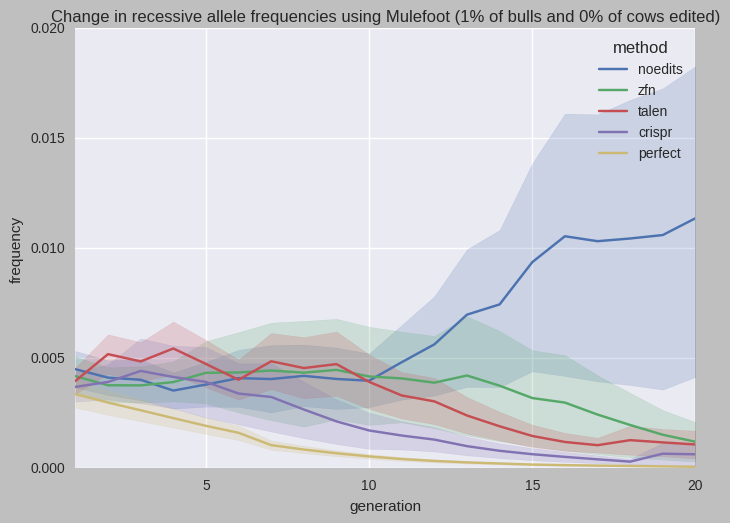

Horned


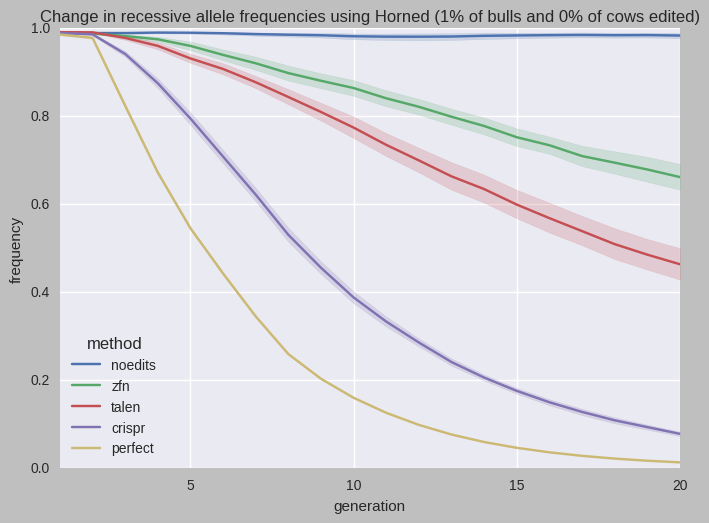

Red


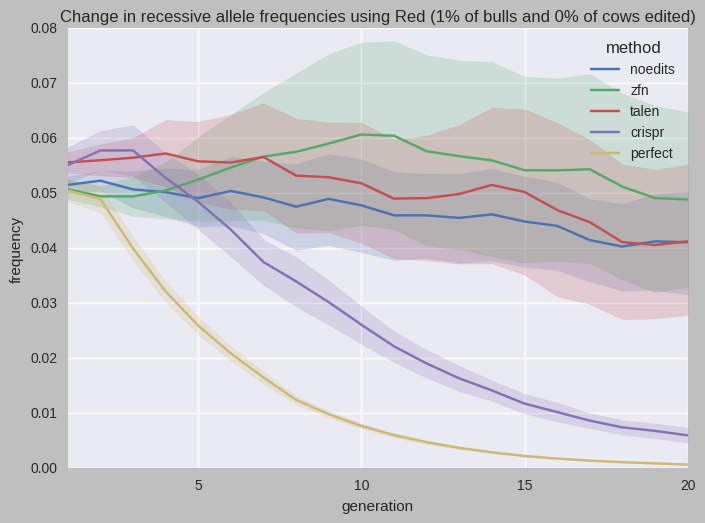

In [11]:
sns.set(style="darkgrid")
for r in all_replicates['recessive'].unique():
    print r
    #sns.tsplot(data=grouped, time="generation", unit="replicate", condition="method", value="frequency")
    sns_plot = sns.tsplot(data=all_replicates[all_replicates['recessive']==r], time="generation", unit="replicate",
               condition="method", value="frequency")
    sns.plt.title('Change in recessive allele frequencies using %s (1%% of bulls and 0%% of cows edited)'%(r))
    plt.show()
    sns_plot.get_figure().savefig('multiple/01_00/rate_of_allele_frequency_change_multiple_01_00_%s.png'%(r), dpi=300)

crispr


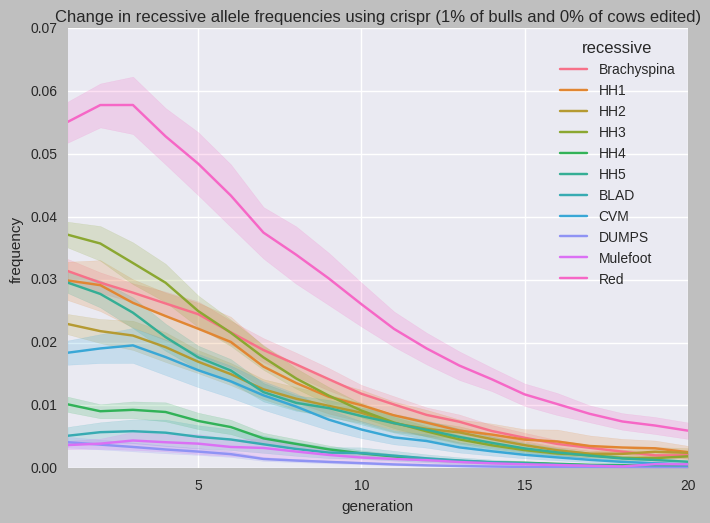

noedits


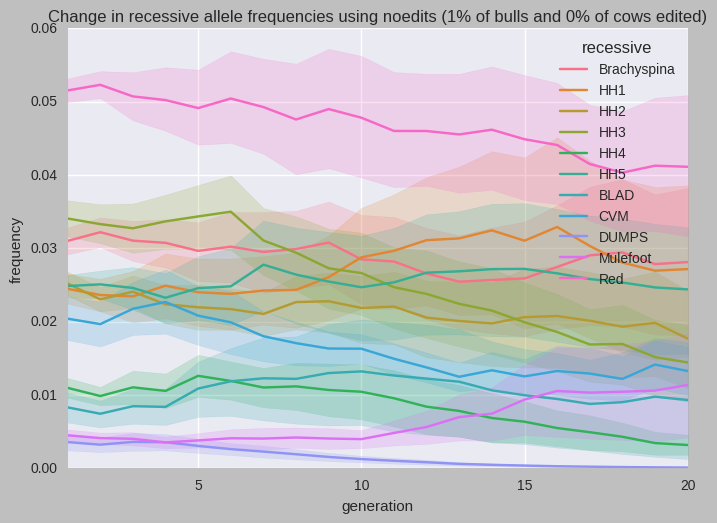

perfect


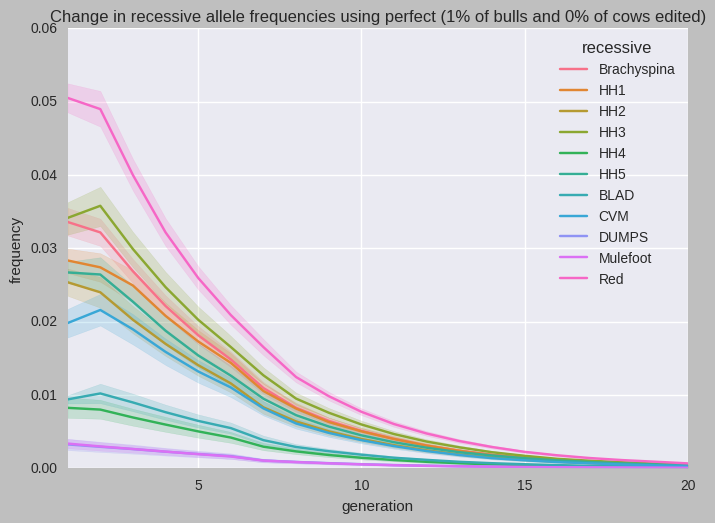

talen


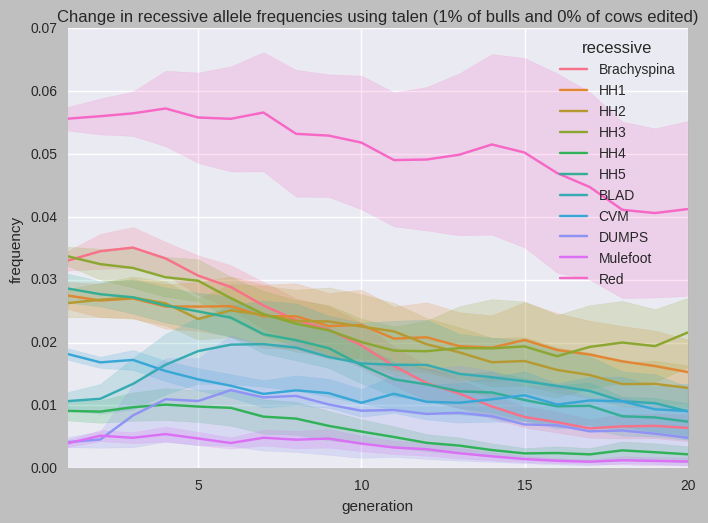

zfn


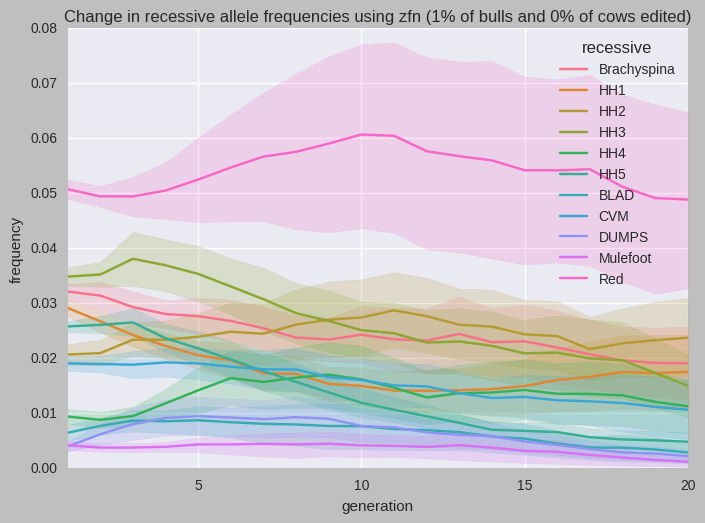

In [27]:
sns.set(style="darkgrid")
for m in all_replicates['method'].unique():
    print m
    sns_plot = sns.tsplot(data=all_replicates[(all_replicates['method']==m) & (all_replicates['recessive'] != 'Horned')],
               time="generation", unit="replicate", condition="recessive", value="frequency")
    sns.plt.title('Change in recessive allele frequencies using %s (1%% of bulls and 0%% of cows edited)'%(m))
    plt.show()
    sns_plot.get_figure().savefig('multiple/01_00/rate_of_allele_frequency_change_multiple_01_00_%s.png'%(m), dpi=300)

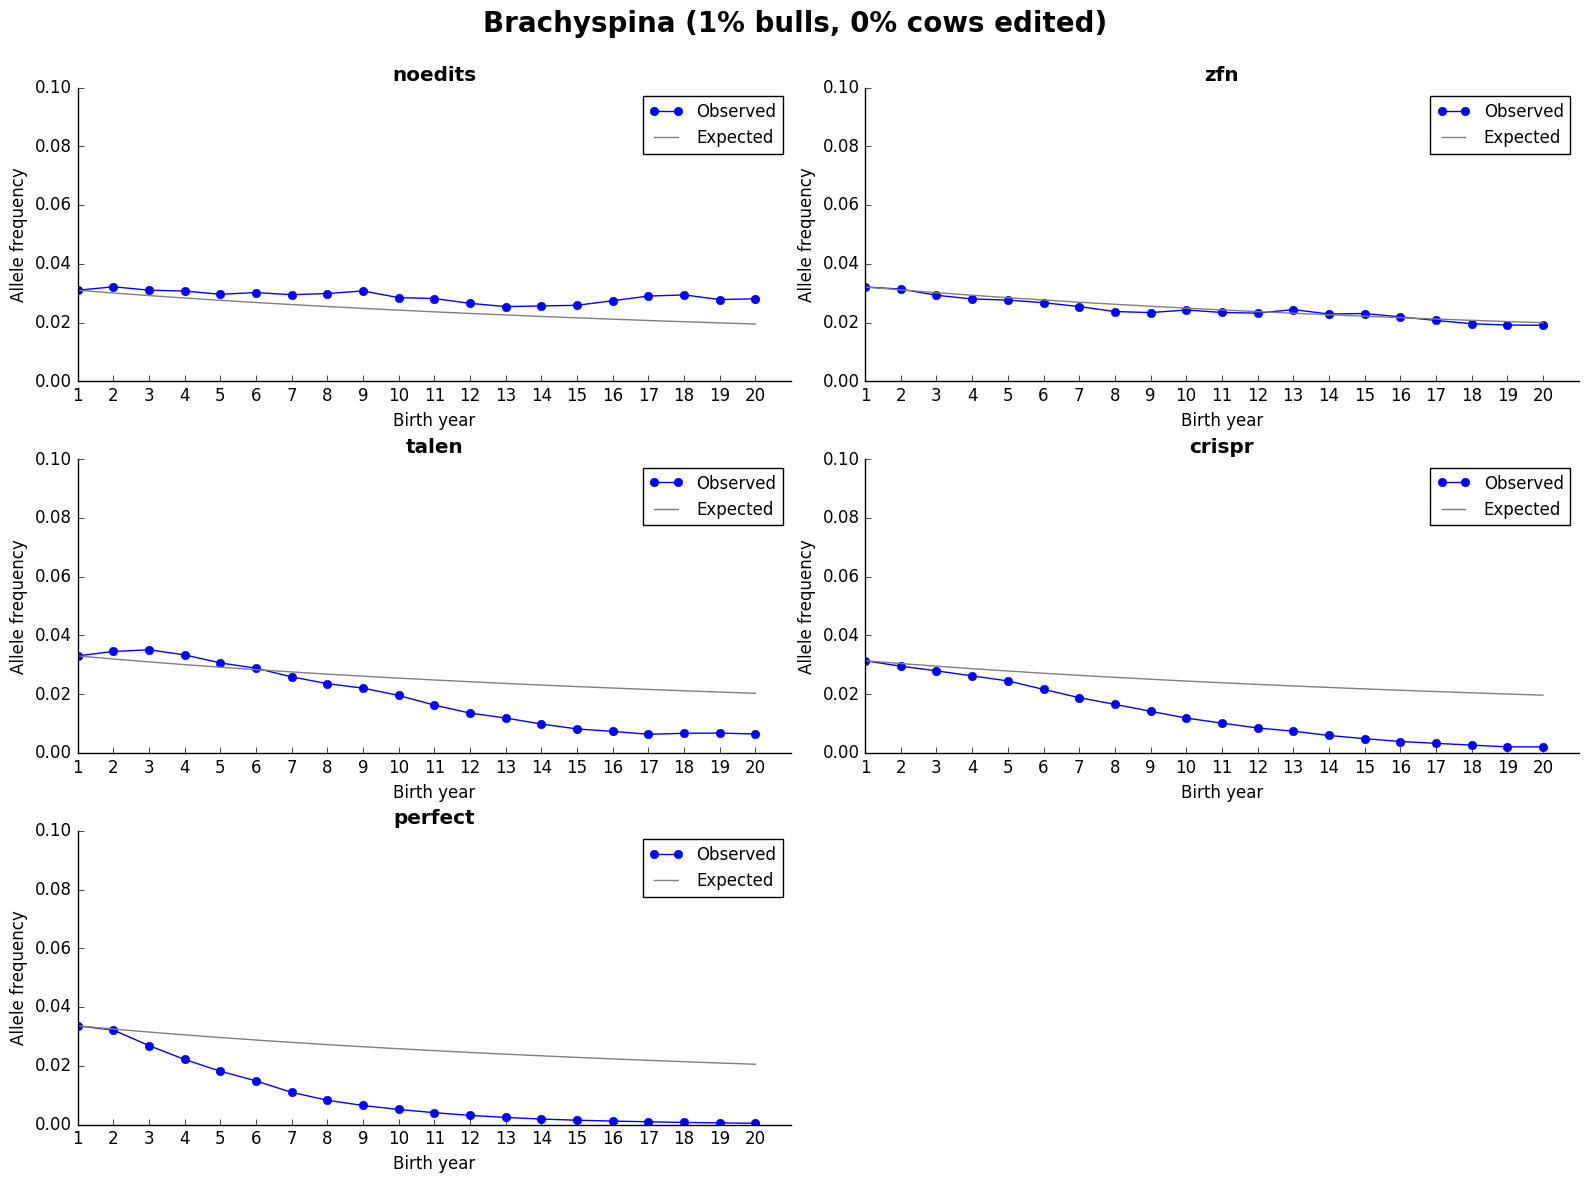

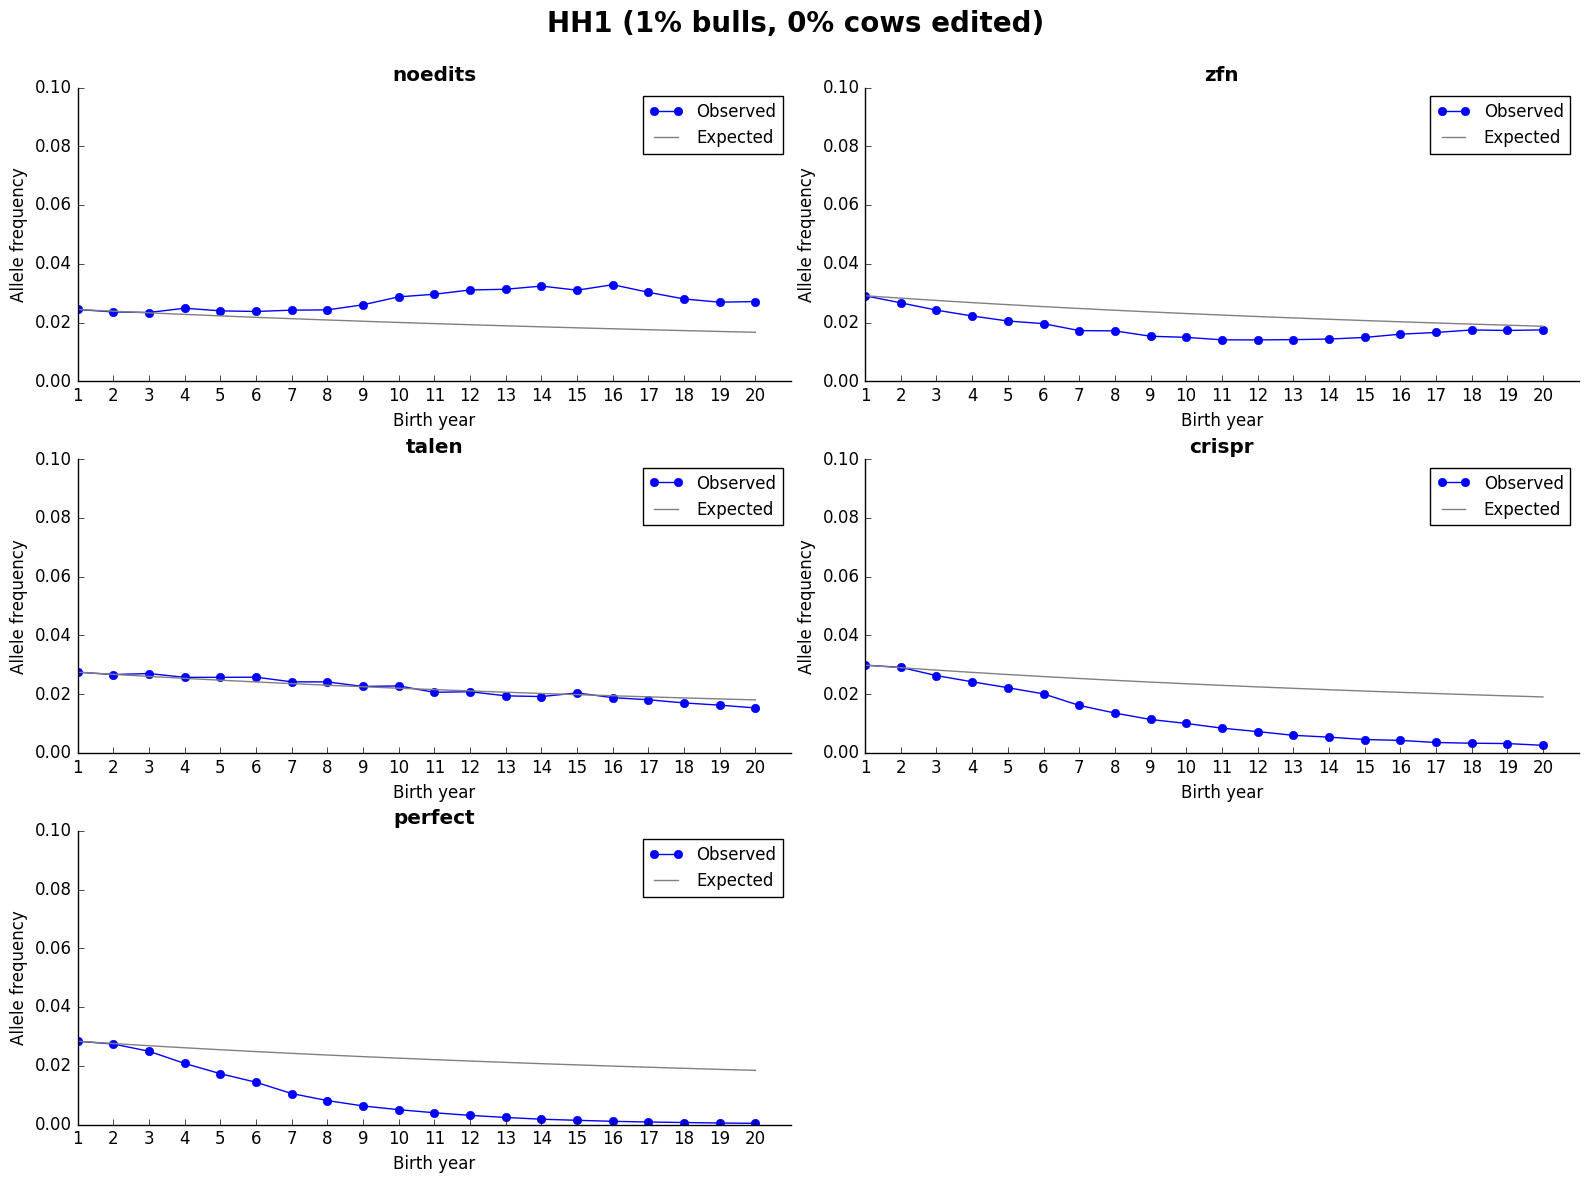

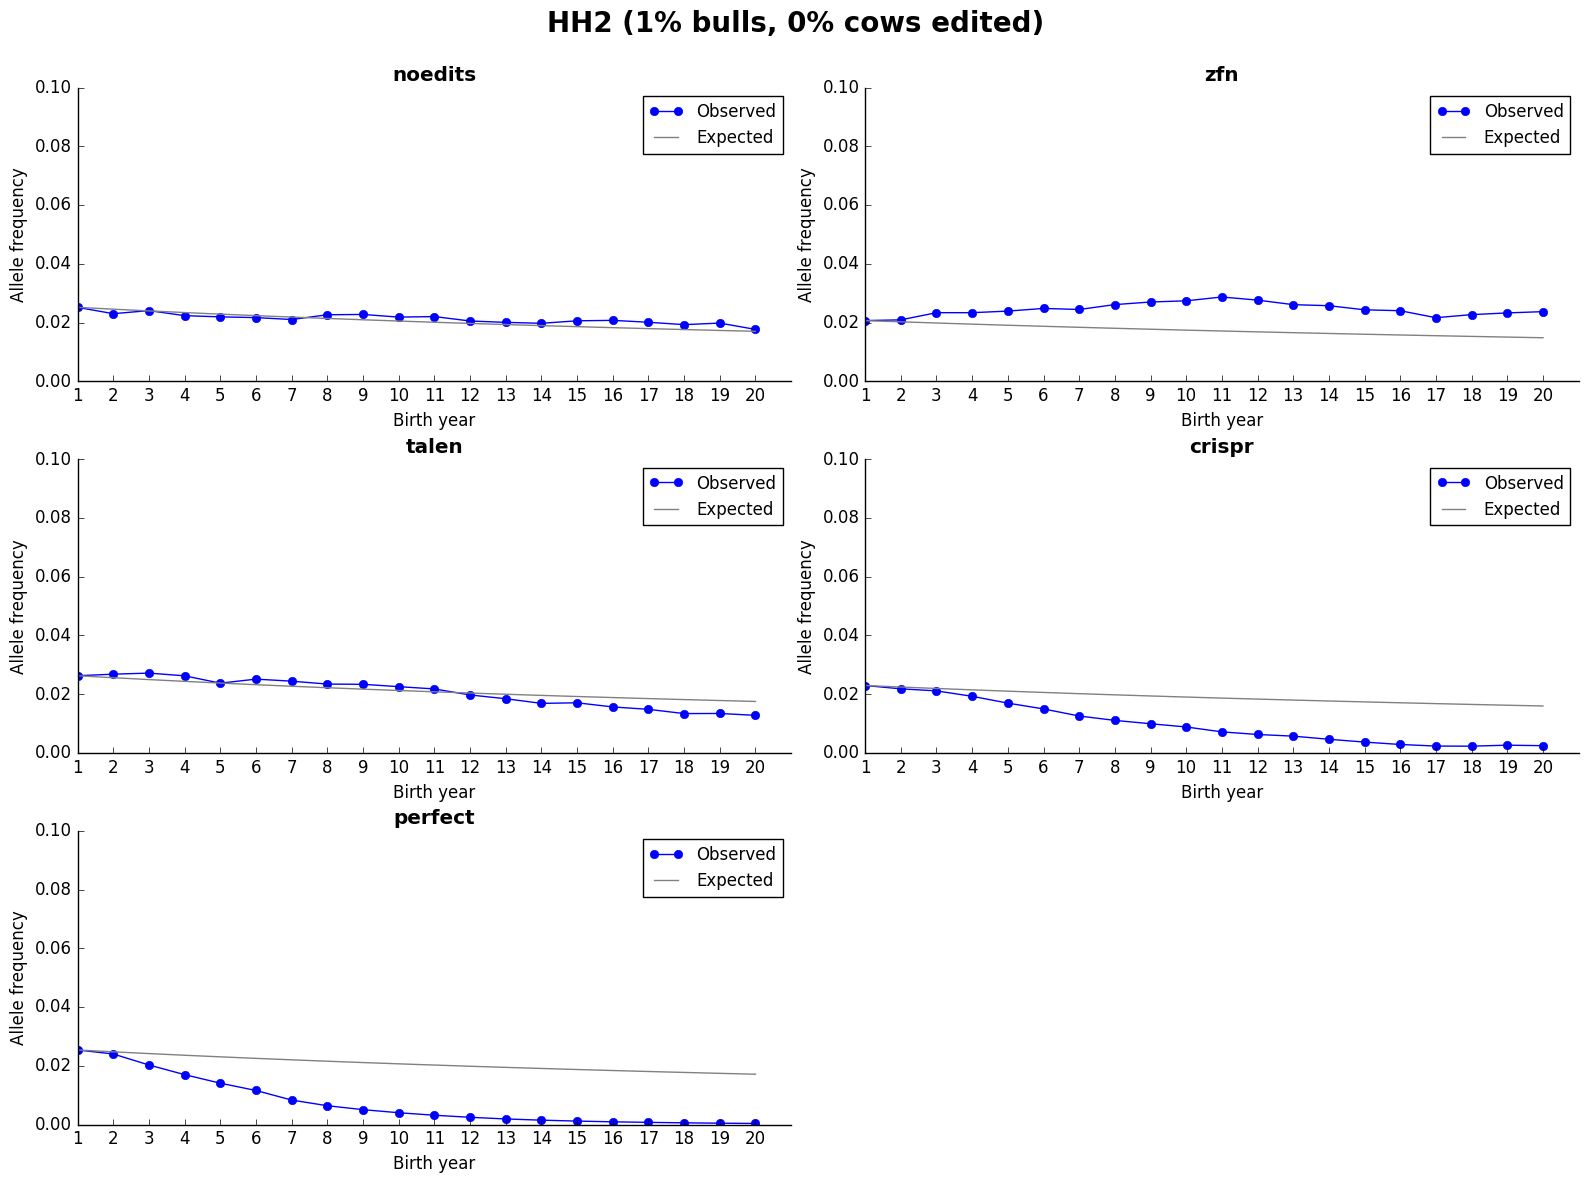

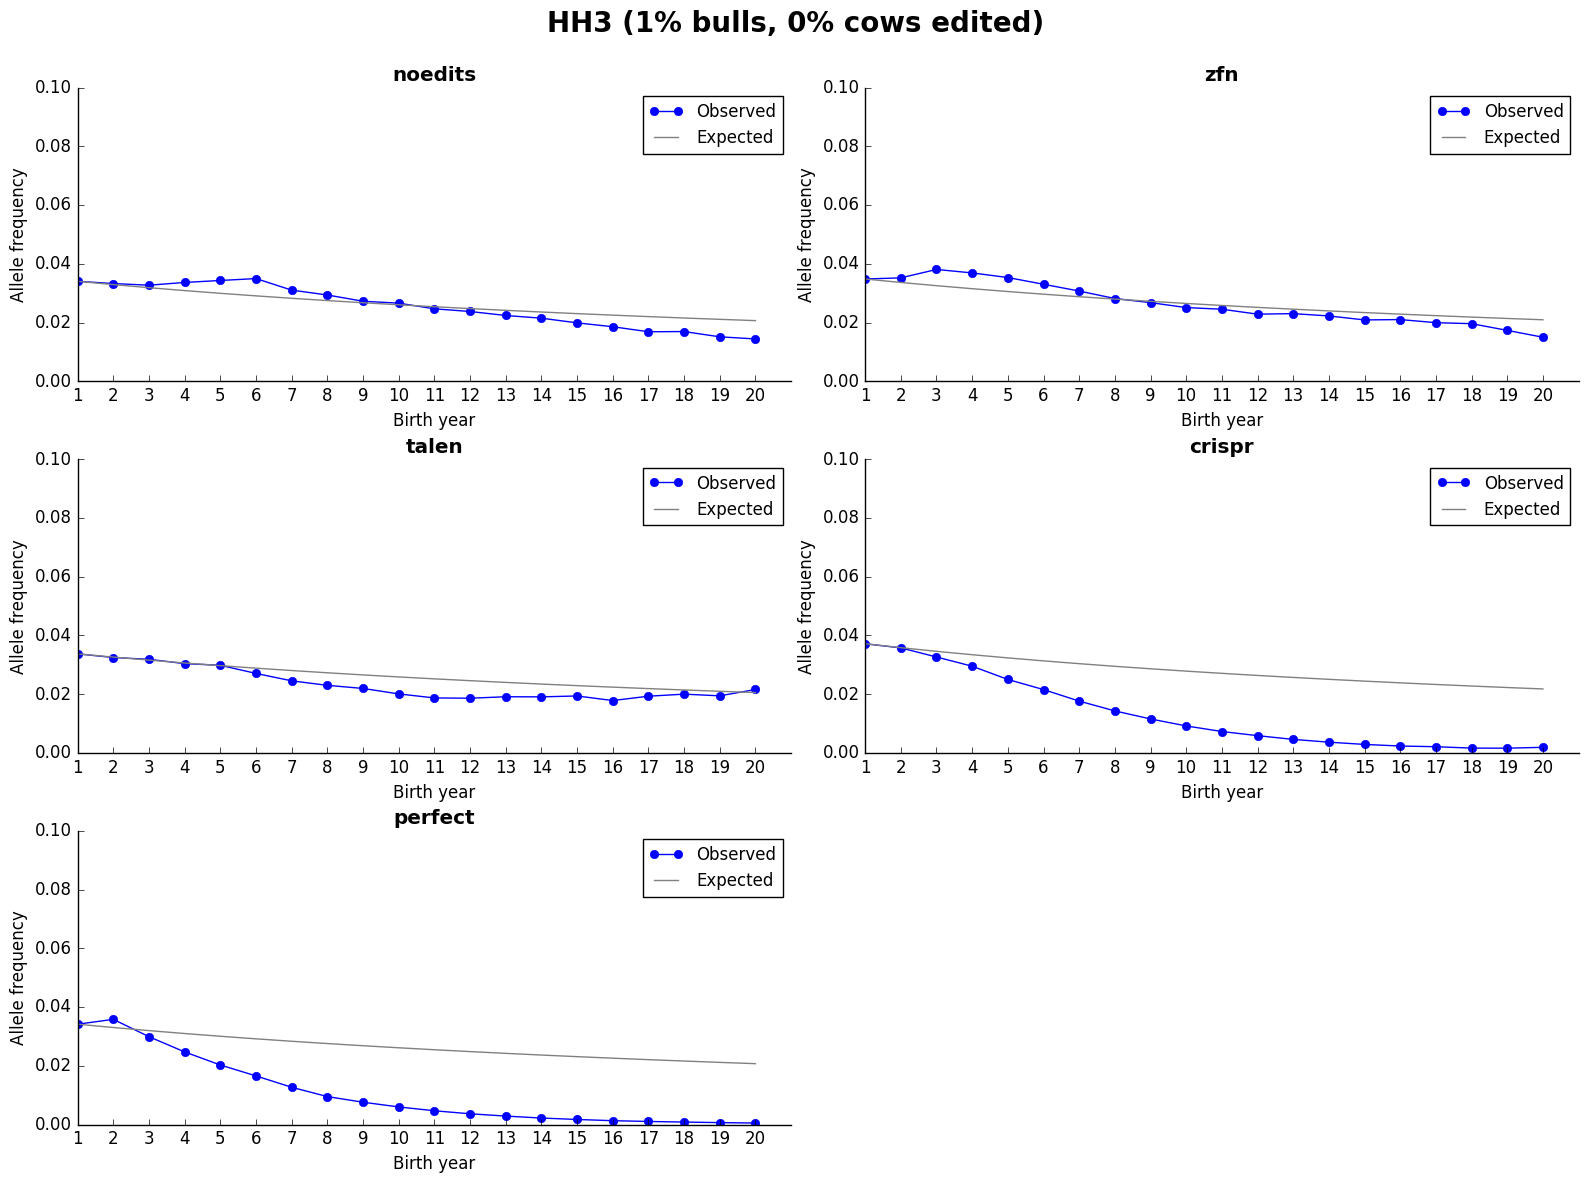

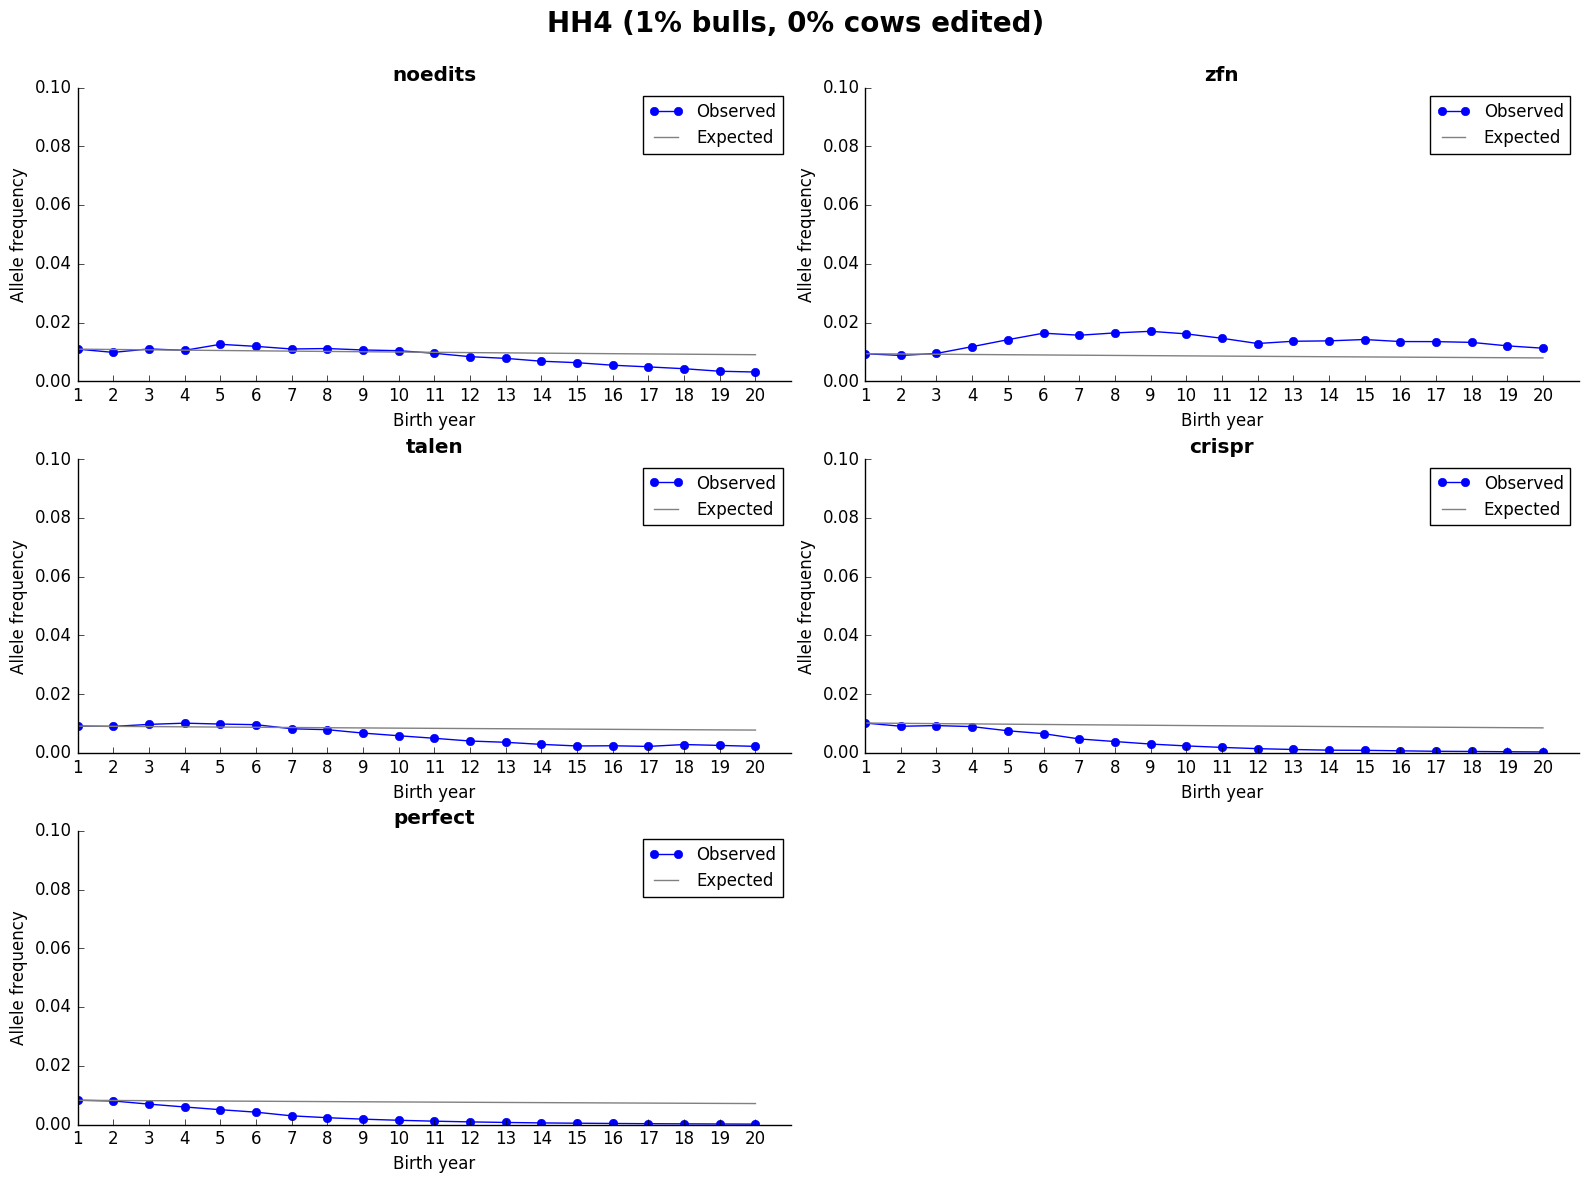

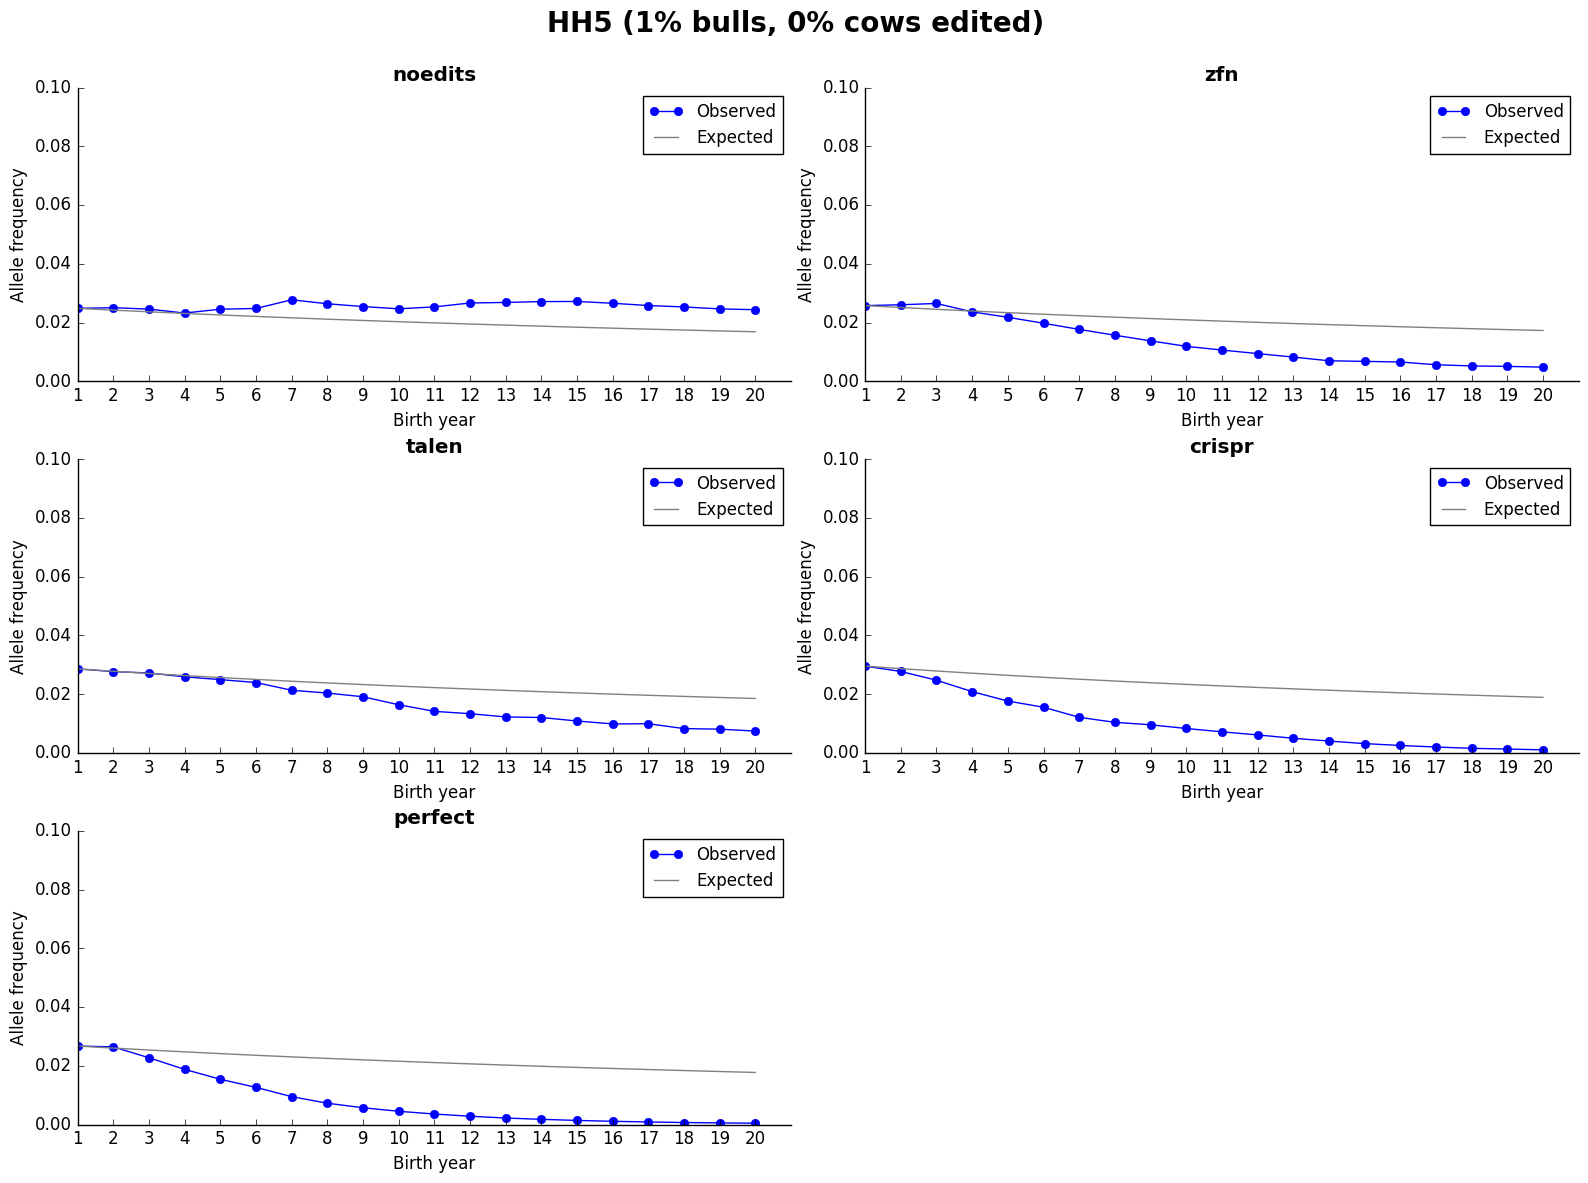

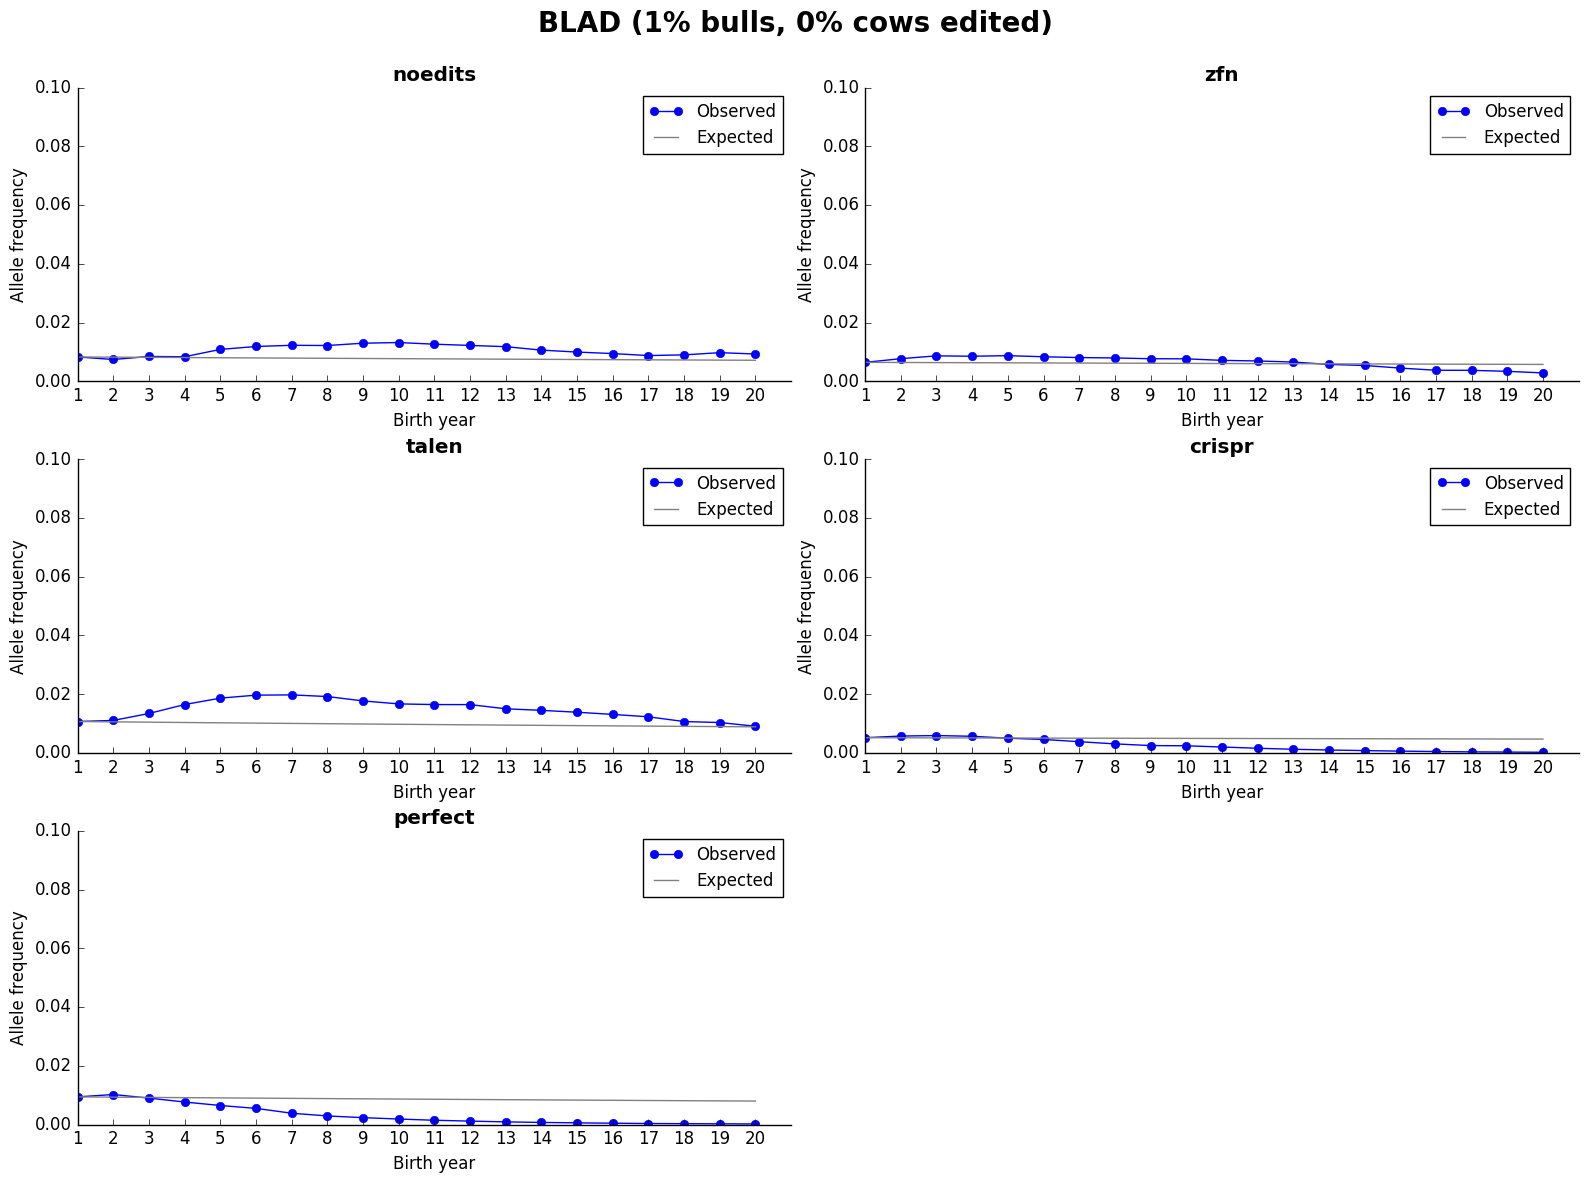

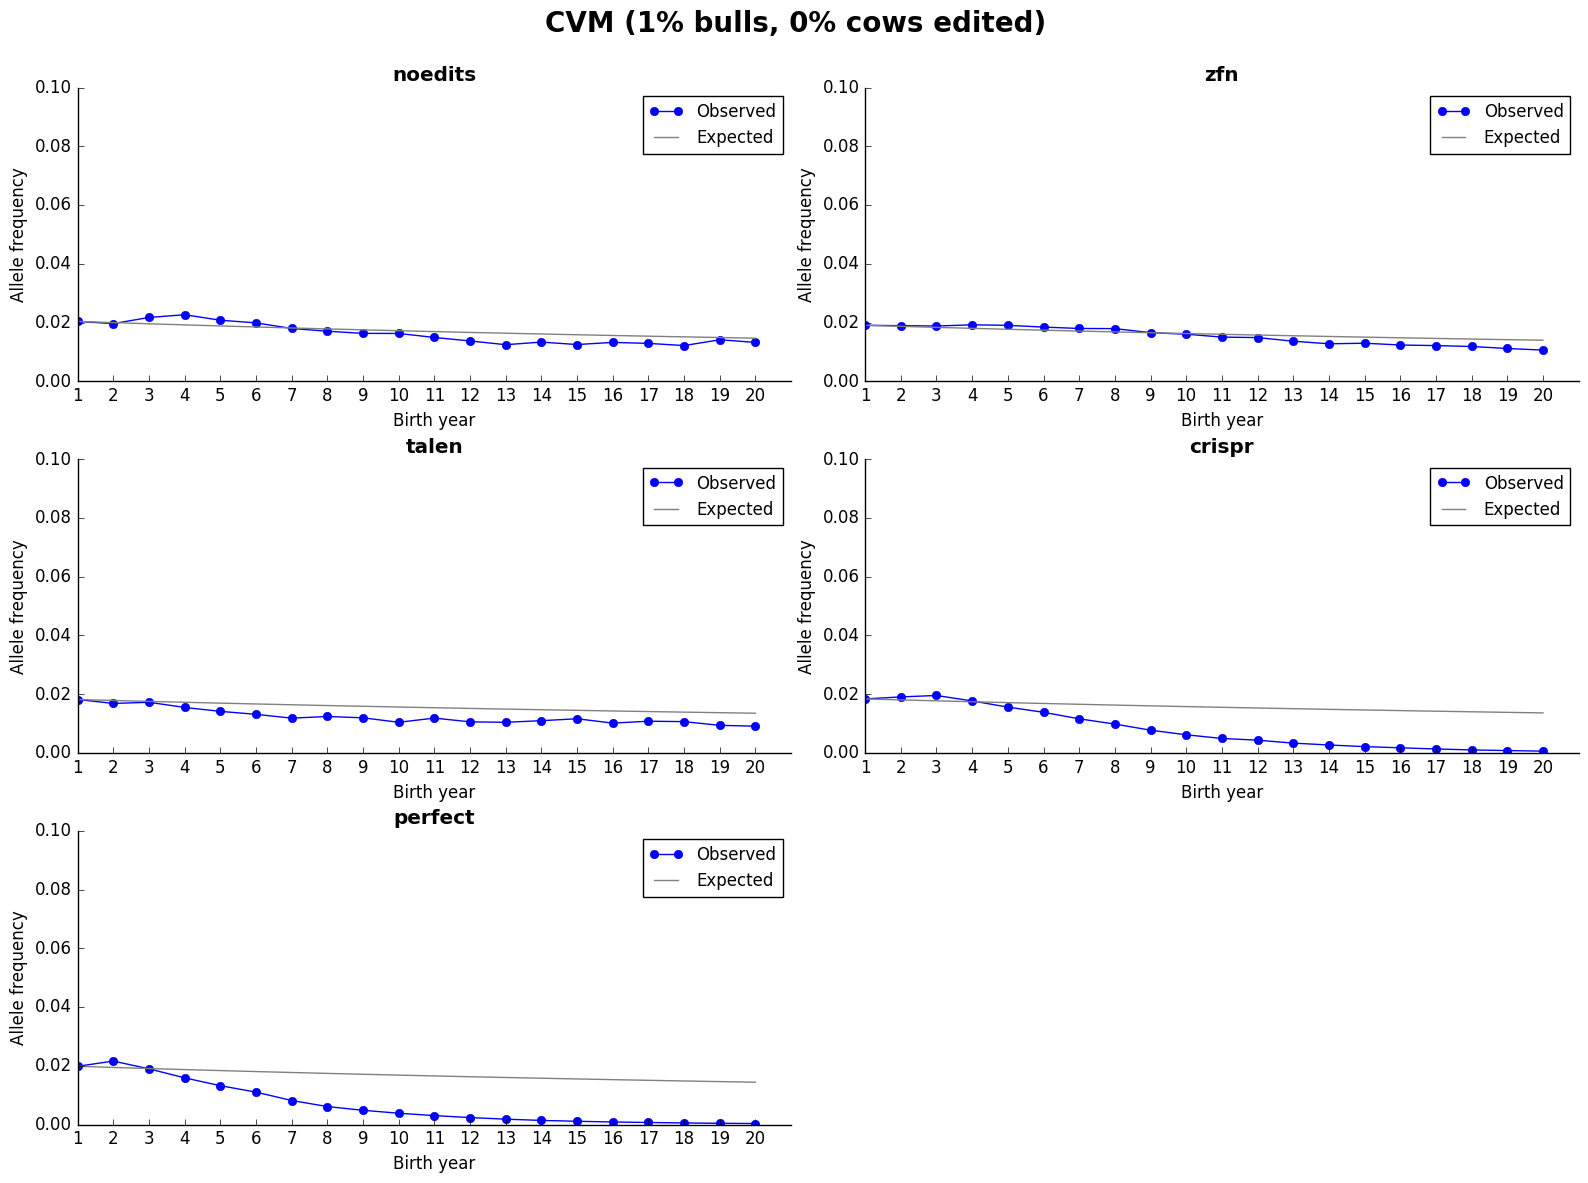

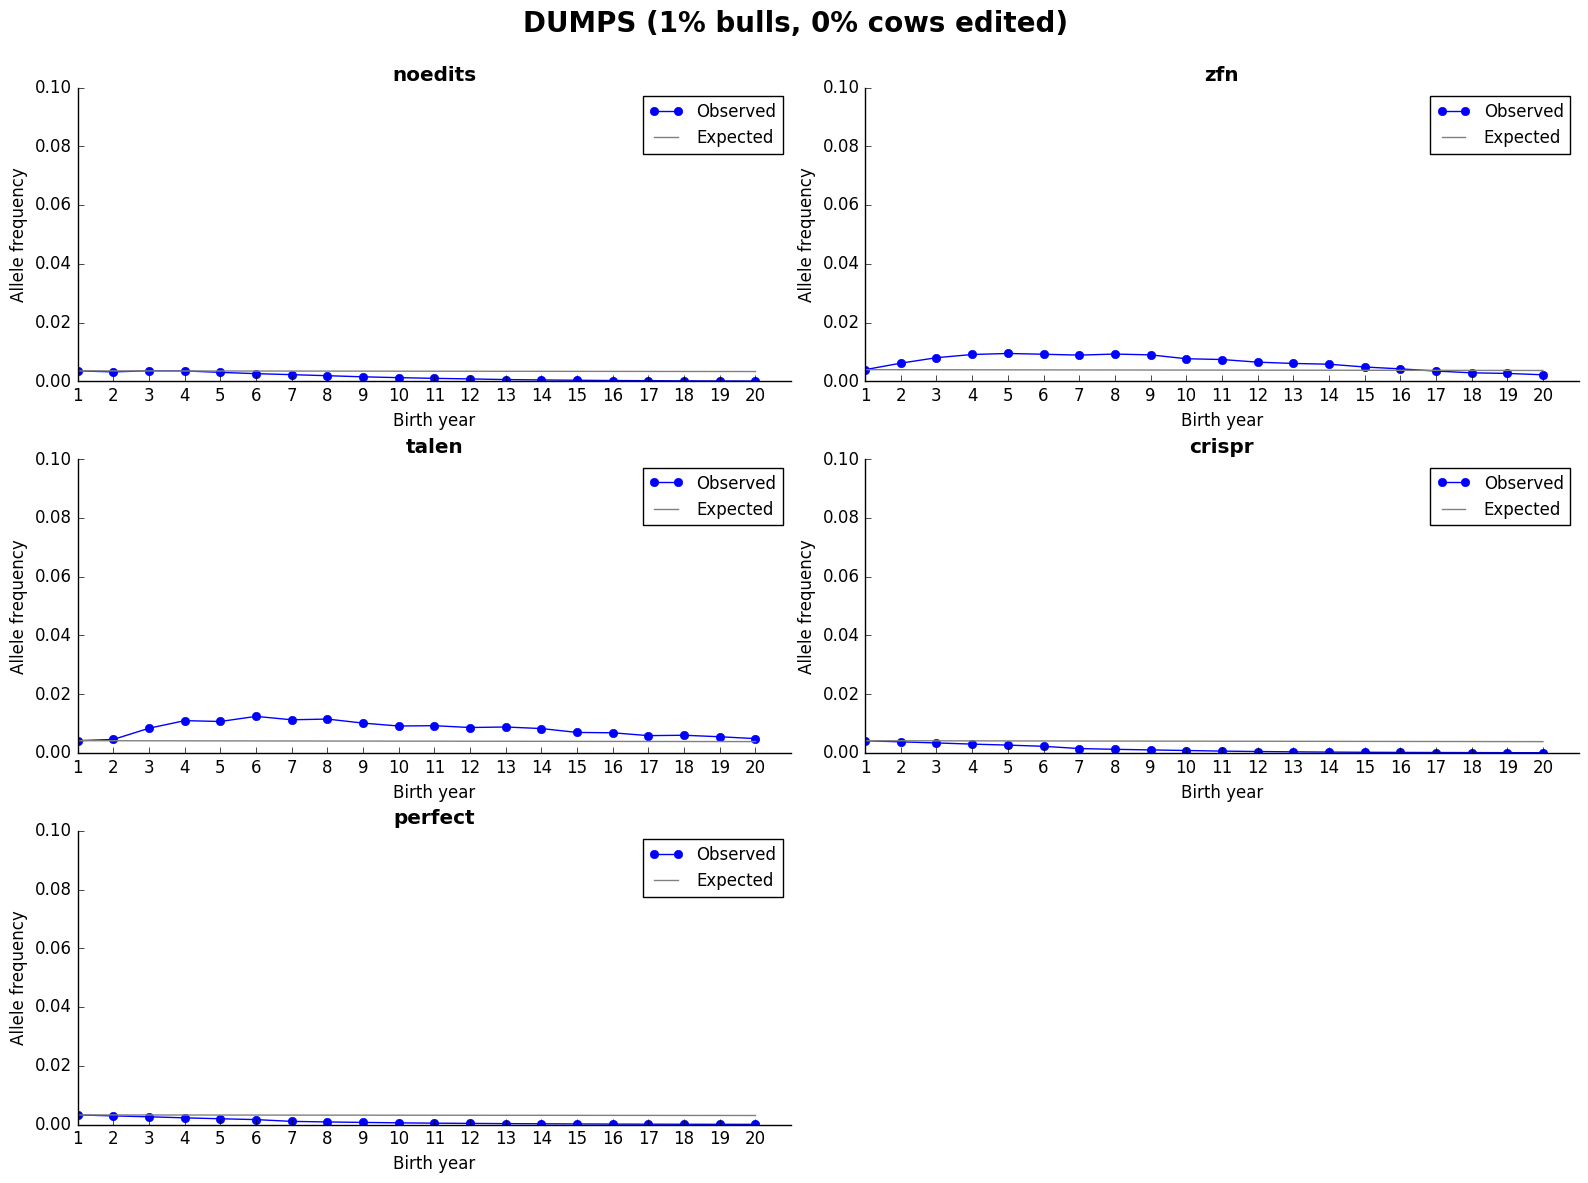

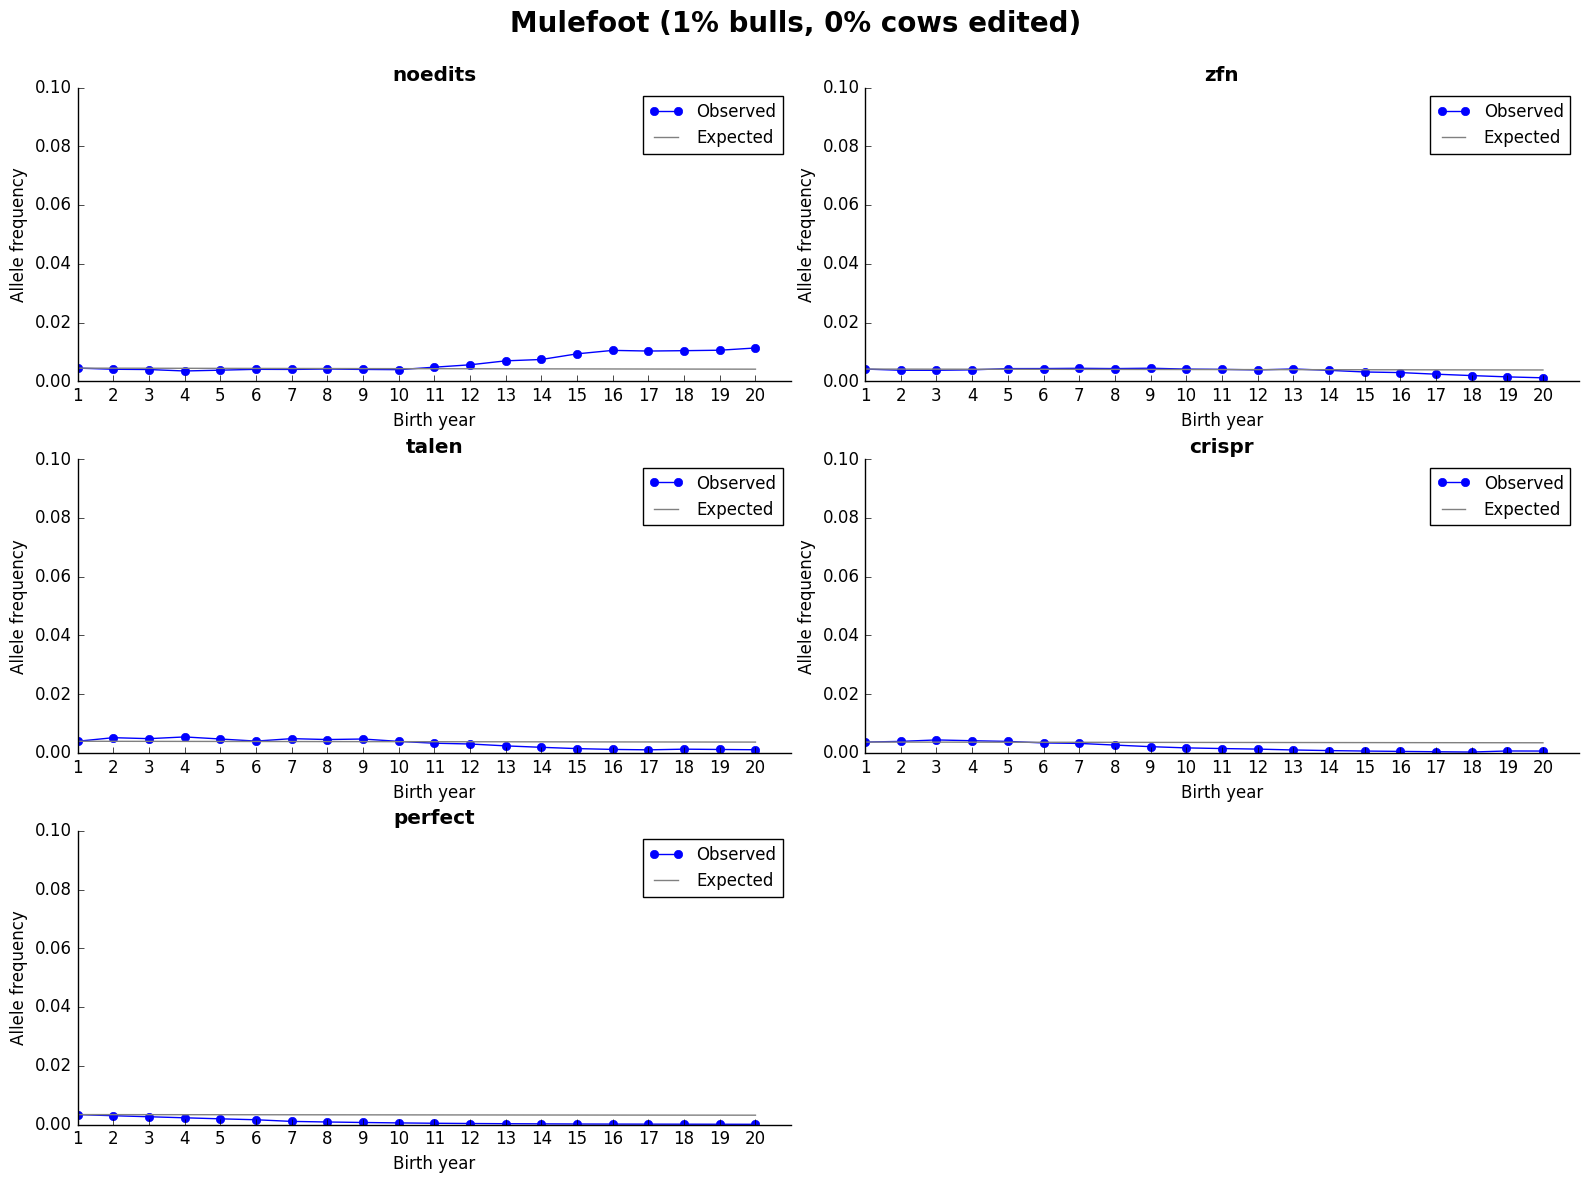

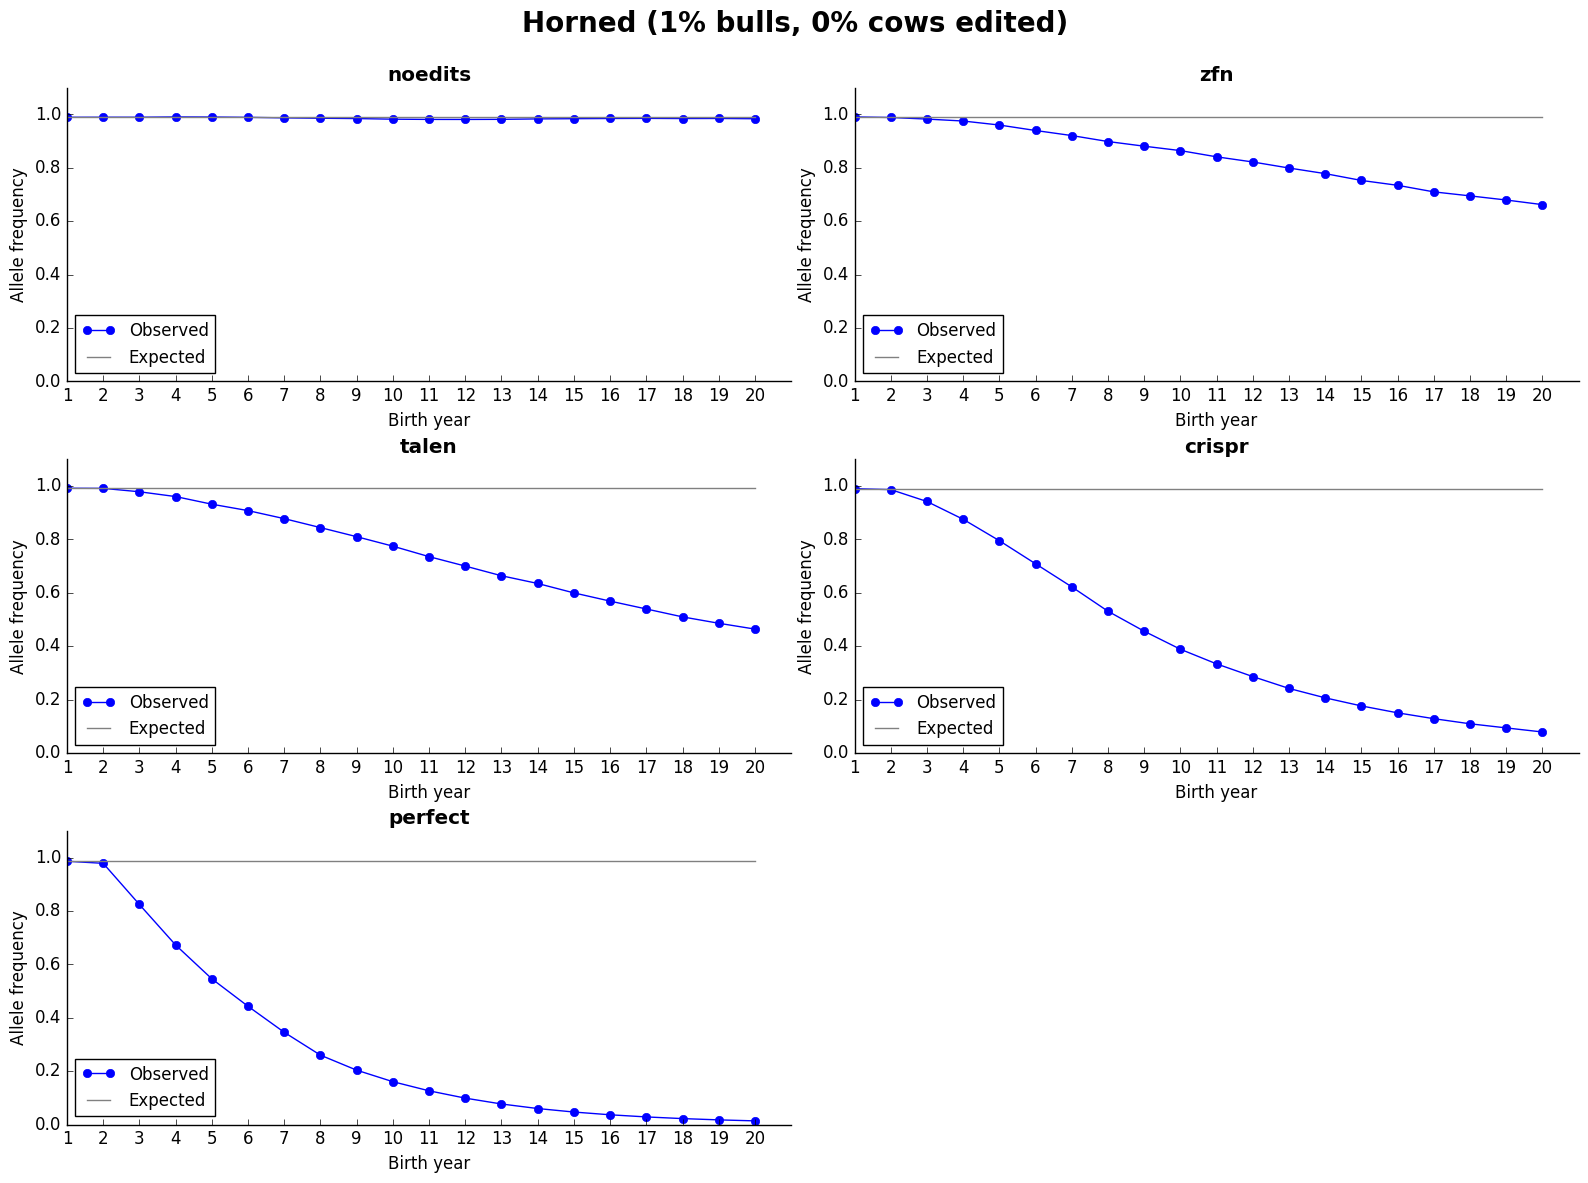

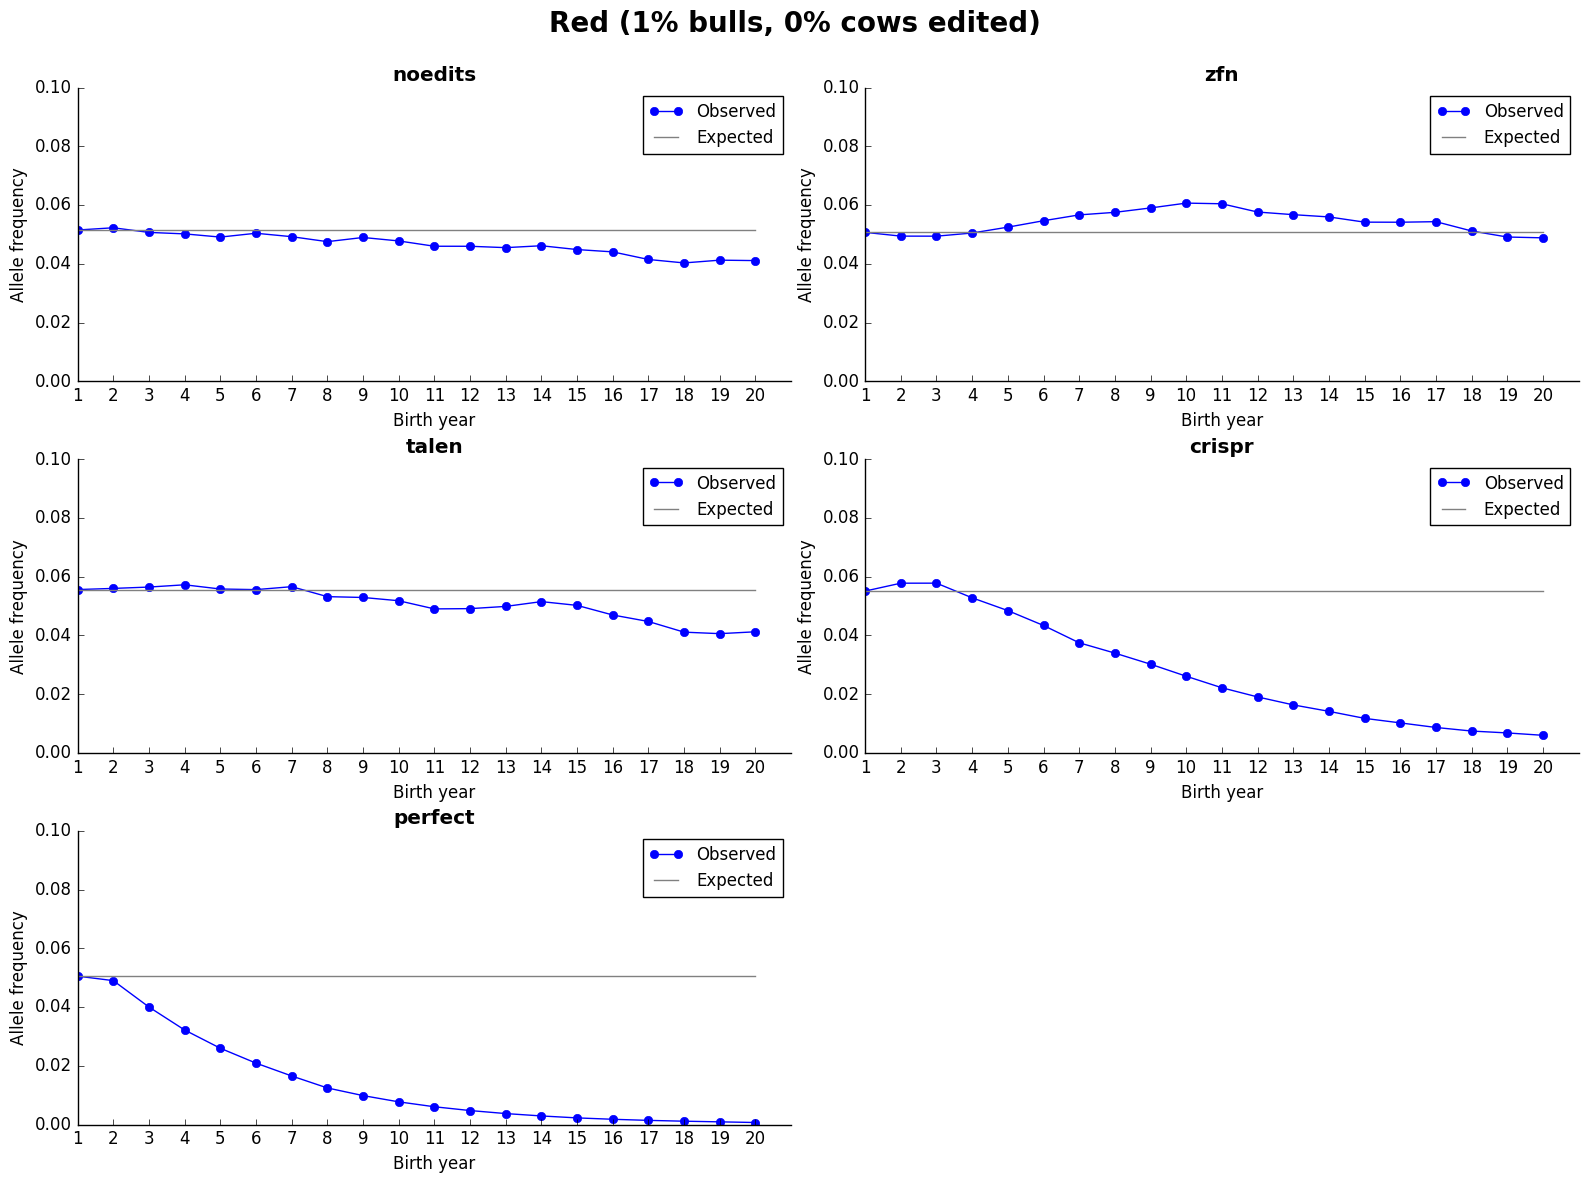

In [11]:
xlabels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
colors = itertools.cycle(['r', 'g', 'b'])
for r in ['Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM', 'DUMPS', 'Mulefoot', 'Horned', 'Red']:
    fig = plt.figure(figsize=(16, 12), dpi=300, facecolor='white')
    for i, m in enumerate(methods):
        ax = fig.add_subplot(3, 2, i+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)  
        ax.set_title(m, weight='bold')
        ax.set_xlabel('Birth year')
        ax.set_ylabel('Allele frequency')
        ax.plot(actual[r][m], label='Observed', marker='o', c='b', mec='b')
        ax.plot(expected[r][m], label='Expected', c='gray')
        if r == 'Horned':
            ax.set_ylim(0.0, 1.1)
        else:
            ax.set_ylim(0.0, 0.10)
        ax.set_xlim(0, 20)
        # Manually set the number of ticks on the plot
        ax.set_xticks(np.arange(20))
        # Apply the tick labels
        ax.set_xticklabels(xlabels)
        # Turn off the top and right tick marks
        plt.tick_params(
            axis='both',       # changes apply to both axes
            which='both',      # both major and minor ticks are affected
            right='off',
            labelright='off',
            top='off',         # ticks along the top edge are off
            labeltop='off')    # labels along the bottom edge are off
        # Place the legend
        ax.legend(loc='best')
    # Use the recessive name as the title for each set of subplots
    plt.suptitle('%s (1%% bulls, 0%% cows edited)'%r, fontsize=20, weight='bold')
    plt.tight_layout(pad=1., w_pad=0.5, h_pad=0.95)
    # Tweak the layout so that the subplot titles don't overlap because tight_layout()
    # ignores suptitle().
    plt.subplots_adjust(top=0.915)
    plt.show()
    filename = 'holstein-act-vs-exp-%s-by-method_01_00.png' % ( r )
    fig.savefig(filename, dpi=300)

Now we have to load the animal records so that we can compute the cumulative genetic gain for each gene editing method.

In [12]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def fit_line(x, y):
    """Return RegressionResults instance of best-fit line."""
    #X = sm.add_constant(x)
    data = {'x':np.array(x), 'y':np.array(y)}
    fit = smf.ols(formula = 'y ~ x + I(x**2)', data=data).fit()
    print fit.summary()
    
    prstd, iv_l, iv_u = wls_prediction_std(fit)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, y, 'o', label="data")
    ax.plot(x, fit.fittedvalues, 'r', label="OLS")
    ax.plot(x, iv_u, 'r--')
    ax.plot(x, iv_l, 'r--')
    ax.legend(loc='best');
    ax.set_ylim(0.0, 0.10)
    ax.set_xlim(0., 20.)
    plt.show()
    
    return fit



==>  noedits
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     236.0
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           3.98e-13
Time:                        08:30:42   Log-Likelihood:                 104.69
No. Observations:                  20   AIC:                            -203.4
Df Residuals:                      17   BIC:                            -200.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0362      0.001     

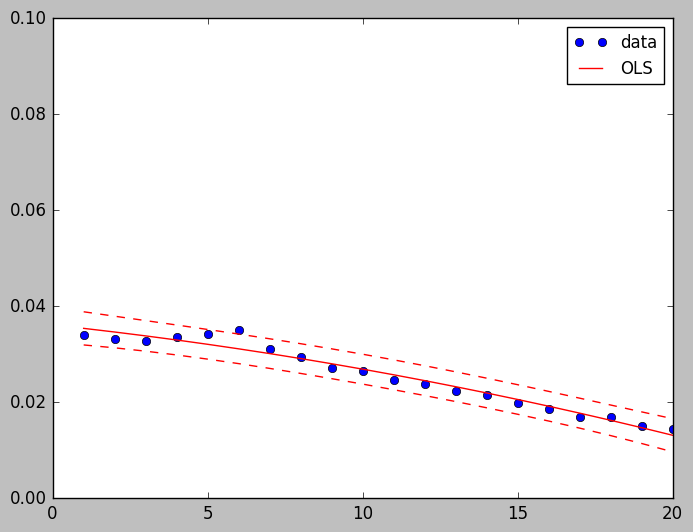



==>  zfn
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     151.8
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           1.44e-11
Time:                        08:30:43   Log-Likelihood:                 100.58
No. Observations:                  20   AIC:                            -195.2
Df Residuals:                      17   BIC:                            -192.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0395      0.001     30.9

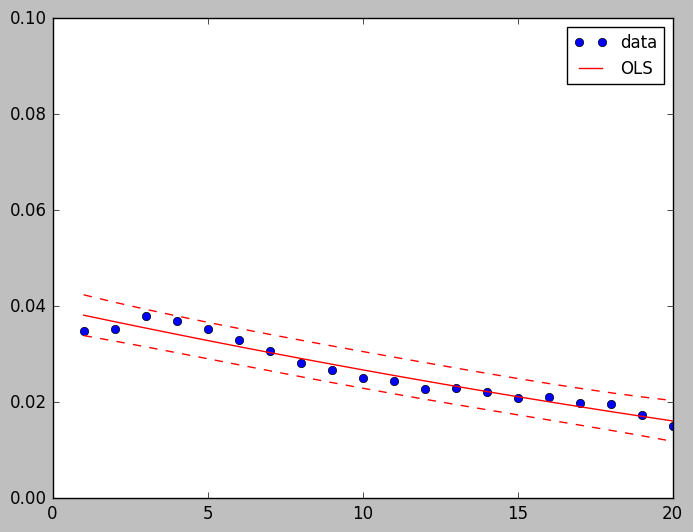



==>  talen
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     223.5
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           6.22e-13
Time:                        08:30:43   Log-Likelihood:                 109.61
No. Observations:                  20   AIC:                            -213.2
Df Residuals:                      17   BIC:                            -210.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0381      0.001     46

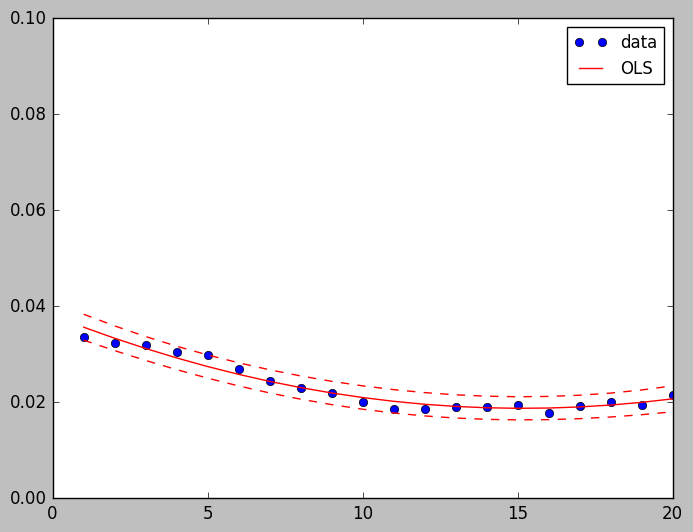



==>  crispr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1431.
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           1.14e-19
Time:                        08:30:44   Log-Likelihood:                 111.08
No. Observations:                  20   AIC:                            -216.2
Df Residuals:                      17   BIC:                            -213.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0445      0.001     5

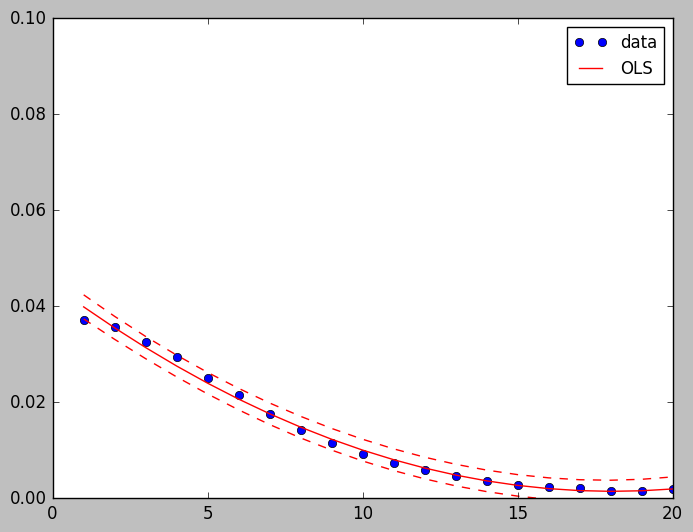



==>  perfect
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     590.5
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           1.96e-16
Time:                        08:30:44   Log-Likelihood:                 103.30
No. Observations:                  20   AIC:                            -200.6
Df Residuals:                      17   BIC:                            -197.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0419      0.001     

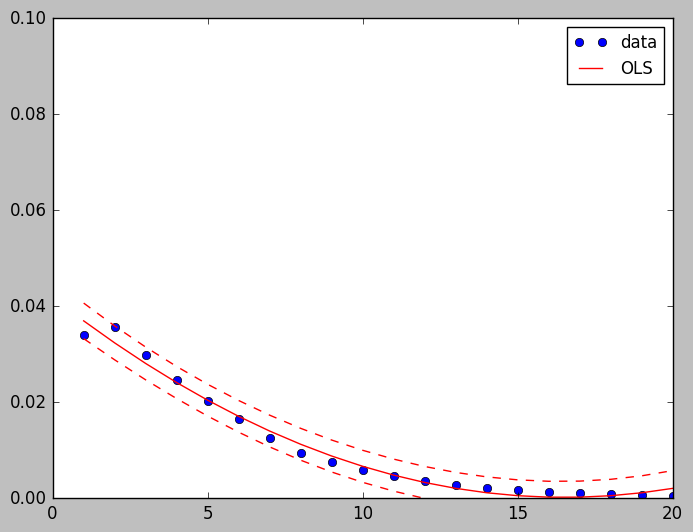

In [13]:
fits = {}
years = [float(i) for i in xrange(1,21)]
for r in ['HH3']:
    fits[r] = {}
    for m in methods:
        print '\n\n==> ', m
        fit = fit_line(y=actual[r][m], x=years)
        fits[r][m] = fit

In [20]:
import statsmodels
print statsmodels.__version__
import matplotlib
print matplotlib.__version__
import seaborn
print seaborn.__version__

0.6.1
1.5.1
0.5.1


In [12]:
#import dask.dataframe as dd
methods = ['crispr', 'noedits', 'perfect', 'talen', 'zfn']
for method in methods:
    print method
    # We have 10 replicates for each simulation
    for sim in xrange(1,11):
        if sim == 1: print '\tReplicate: ', sim,
        elif sim < 10: print ', ', sim,
        else: print ', ', sim, ''
        # Load the individual history files
        #print '\t\tReading live cows.'
        lc = pd.read_csv('multiple/01_00/%s/%s/cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        #print '\t\tReading dead cows.'
        dc = pd.read_csv('multiple/01_00/%s/%s/dead_cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        #print '\t\tReading live bulls.'
        lb = pd.read_csv('multiple/01_00/%s/%s/bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        #print '\t\tReading dead bulls.'
        db = pd.read_csv('multiple/01_00/%s/%s/dead_bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        # Stack the individual animal datasets
        #print '\t\tConcatenating animal datasets'
        all_animals = pd.concat([lc, dc, lb, db], axis=0)
        all_animals['replicate'] = sim
        all_animals['method'] = method
        if method == methods[0] and sim == 1:
            #print '\t\tCreating initial dataframe for replicates.'
            #all_replicates = all_animals
            grouped = all_animals.groupby(['born', 'method']).mean().reset_index()
        else:
            #print '\t\tCreating successive dataframe for replicates.'
            grouped = pd.concat([grouped, all_animals.groupby(['born', 'method']).mean().reset_index()])

crispr
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
noedits
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
perfect
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
talen
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
zfn
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 


In [17]:
all_replicates['method'].value_counts()

noedits    2400
crispr     2400
zfn        2400
talen      2400
perfect    2400
Name: method, dtype: int64

In [18]:
#grouped = all_replicates.groupby(['born', 'method']).mean().reset_index()
grouped.head()

born  method        animal  sire  dam        herd      died         TBV  \
0    -9  crispr  35164.305556   0.0  0.0   97.472222  1.111111  296.892403   
0    -9  crispr  35178.744186   0.0  0.0   99.674419  1.139535  351.300808   
0    -9  crispr  35175.371429   0.0  0.0  107.371429  1.228571  335.530526   
0    -9  crispr  35175.400000   0.0  0.0   91.350000  1.125000  324.660528   
0    -9  crispr  35148.562500   0.0  0.0  102.000000  1.093750  273.796082   

   inbreeding  replicate  
0         0.0        1.0  
0         0.0        2.0  
0         0.0        3.0  
0         0.0        4.0  
0         0.0        5.0

In [19]:
grouped.sort_values(by=['method','born'], inplace=True)

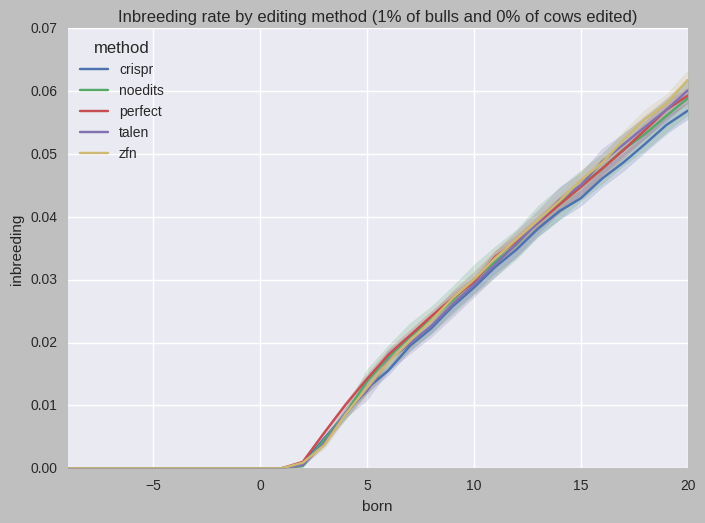

In [20]:
# Plot inbreeding by method
sns_plot = sns.tsplot(data=grouped, time="born", unit="replicate", condition="method", value="inbreeding")
sns.plt.title('Inbreeding rate by editing method (1% of bulls and 0% of cows edited)')
plt.show()
sns_plot.get_figure().savefig('multiple/01_00/rate_of_inbreeding_change_multiple_01_00.png', dpi=300)

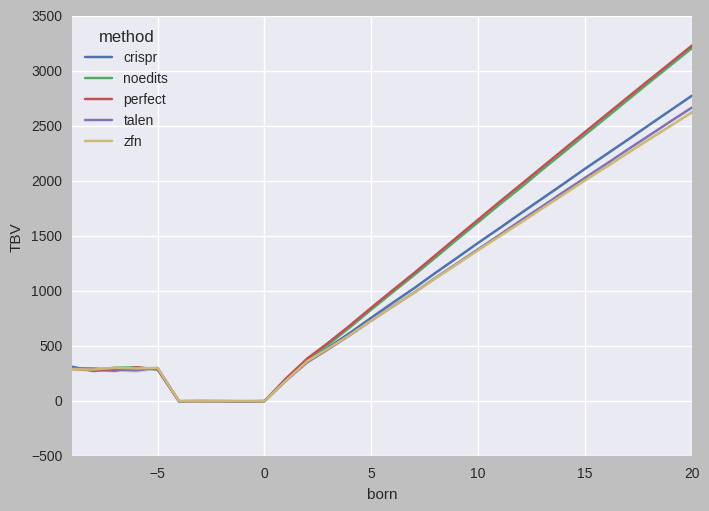

In [21]:
sns.tsplot(data=grouped, time="born", unit="replicate", condition="method", value="TBV")
plt.show()

In [22]:
# http://stackoverflow.com/questions/22650833/pandas-groupby-cumulative-sum
grouped['TBV_cumulative'] = grouped.groupby(['method'])['TBV'].apply(lambda x: x.cumsum())

In [23]:
grouped.describe()

born        animal          sire           dam         herd  \
count  1500.000000  1.500000e+03  1.500000e+03  1.500000e+03  1500.000000   
mean      5.500000  6.106437e+05  4.960165e+05  4.594257e+05    99.327319   
std       8.658328  6.184438e+05  5.599632e+05  5.320496e+05     4.060065   
min      -9.000000  1.730947e+04  0.000000e+00  0.000000e+00    70.083333   
25%      -2.000000  3.517539e+04  0.000000e+00  0.000000e+00    99.069511   
50%       5.500000  3.939048e+05  2.241964e+05  1.857808e+05    99.476031   
75%      13.000000  1.143979e+06  9.629343e+05  8.929605e+05    99.858776   
max      20.000000  1.844734e+06  1.693306e+06  1.594397e+06   121.562500   

              died          TBV   inbreeding    replicate  TBV_cumulative  
count  1500.000000  1500.000000  1500.000000  1500.000000     1500.000000  
mean      7.782239  1092.360834     0.020224     5.500000    86967.890435  
std       5.170868   957.189074     0.021128     2.873239    93617.367111  
min       1.000000    -7.018977     0.000000     1.000000      287.008973  
25%       3.259366   282.601957     0.000000     3.000000    14894.920605  
50%       6.493160   849.829843     0.014467     5.500000    40151.260531  
75%      13.006077  1908.867687     0.038738     8.000000   143842.137785  
max      15.387800  3314.637432     0.075269    10.000000   360650.151860

In [24]:
grouped['method'].value_counts()

zfn        300
talen      300
noedits    300
perfect    300
crispr     300
Name: method, dtype: int64

In [25]:
for method in grouped['method'].value_counts().keys():
    print method, grouped.loc[(grouped['method'] == method) & (grouped['born'] == 20)]['TBV_cumulative']

zfn 29    277844.081488
29    280491.544139
29    283109.535323
29    285768.876677
29    288369.856297
29    290976.869903
29    293656.557359
29    296304.319221
29    298931.855119
29    301555.381234
Name: TBV_cumulative, dtype: float64
talen 29    280037.717091
29    282706.036155
29    285415.395235
29    288087.906851
29    290755.148986
29    293440.839834
29    296075.038239
29    298730.587554
29    301367.919180
29    304080.191156
Name: TBV_cumulative, dtype: float64
noedits 29    327736.912531
29    330951.411191
29    334135.702031
29    337344.515239
29    340566.844463
29    343806.190024
29    347034.156203
29    350229.544271
29    353447.698349
29    356619.165625
Name: TBV_cumulative, dtype: float64
perfect 29    331530.286276
29    334798.886185
29    338035.681023
29    341229.204648
29    344465.551590
29    347706.908788
29    350914.549051
29    354115.435197
29    357430.072629
29    360650.151860
Name: TBV_cumulative, dtype: float64
crispr 29    290630.953488

In [26]:
for method in grouped['method'].value_counts().keys():
    print method, 'mean: ', grouped.loc[(grouped['method'] == method) & (grouped['born'] == 20)]['TBV_cumulative'].mean(),
    print 'stderr: ', grouped.loc[(grouped['method'] == method) & (grouped['born'] == 20)]['TBV_cumulative'].std()

import scipy.stats as stats
for pop1 in grouped['method'].value_counts().keys():
    for pop2 in grouped['method'].value_counts().keys():
        if pop1 != pop2:
            print pop1, ' ', pop2
            print stats.ttest_ind(a=grouped.loc[(grouped['method'] == pop1) & (grouped['born'] == 20)]['TBV_cumulative'],
                            b=grouped.loc[(grouped['method'] == pop2) & (grouped['born'] == 20)]['TBV_cumulative'],
                            equal_var=False)

zfn mean:  289700.887676 stderr:  7977.01337275
talen mean:  292069.678028 stderr:  8078.1479302
noedits mean:  342187.213993 stderr:  9728.71691188
perfect mean:  346087.672725 stderr:  9783.80876812
crispr mean:  303138.417293 stderr:  8416.7110846
zfn   talen
Ttest_indResult(statistic=-0.65980915013468866, pvalue=0.51773185351276618)
zfn   noedits
Ttest_indResult(statistic=-13.192655723780874, pvalue=1.7981675873081217e-10)
zfn   perfect
Ttest_indResult(statistic=-14.125167022341317, pvalue=6.2393229852906834e-11)
zfn   crispr
Ttest_indResult(statistic=-3.6643812113508694, pvalue=0.0017809395301441842)
talen   zfn
Ttest_indResult(statistic=0.65980915013468866, pvalue=0.51773185351276618)
talen   noedits
Ttest_indResult(statistic=-12.533128558943353, pvalue=3.8166926648800799e-10)
talen   perfect
Ttest_indResult(statistic=-13.463355760733895, pvalue=1.2590864611741667e-10)
talen   crispr
Ttest_indResult(statistic=-3.000358047917008, pvalue=0.0076898861985328177)
noedits   zfn
Ttest_i

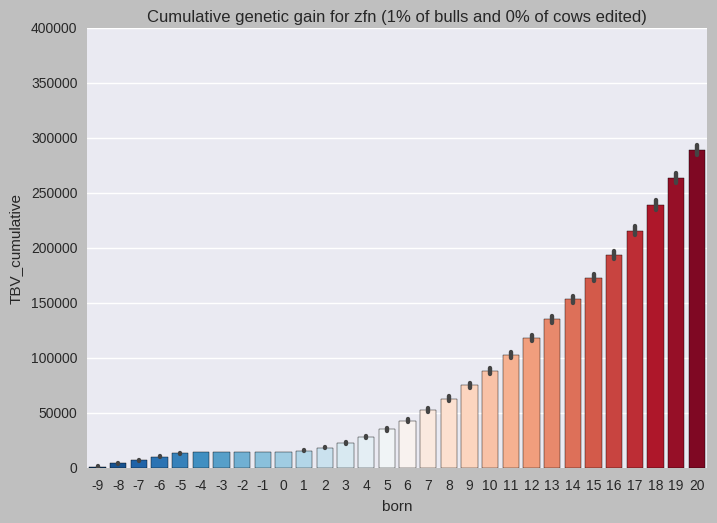

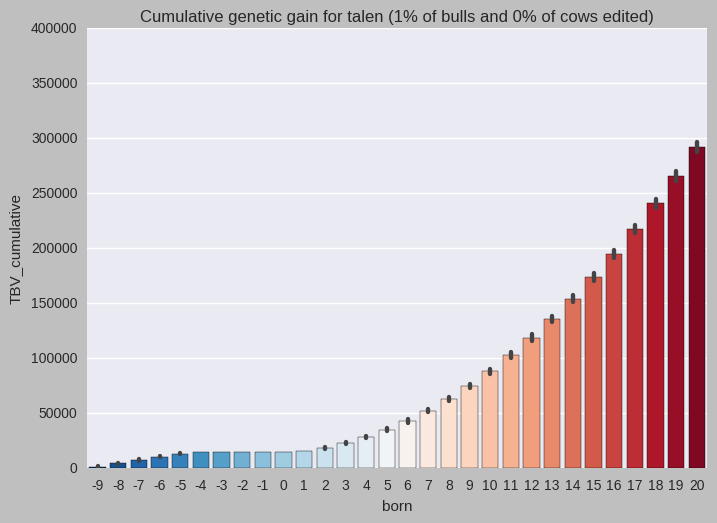

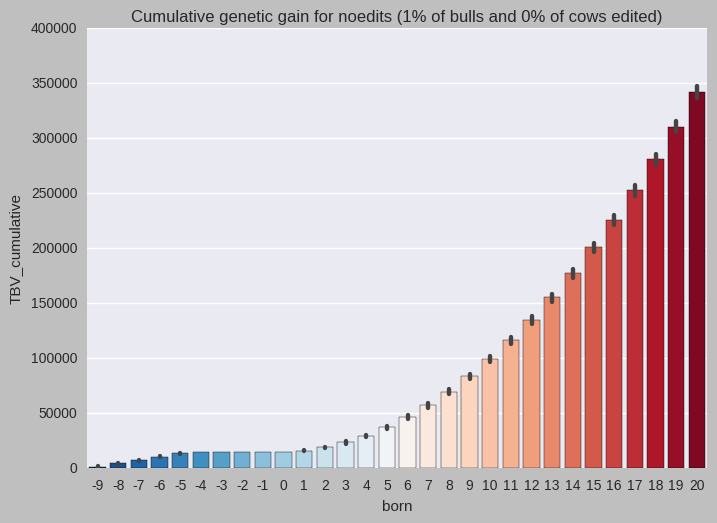

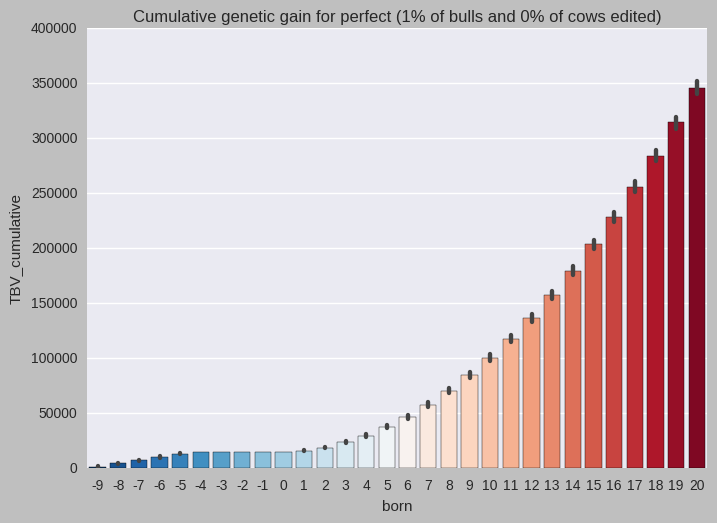

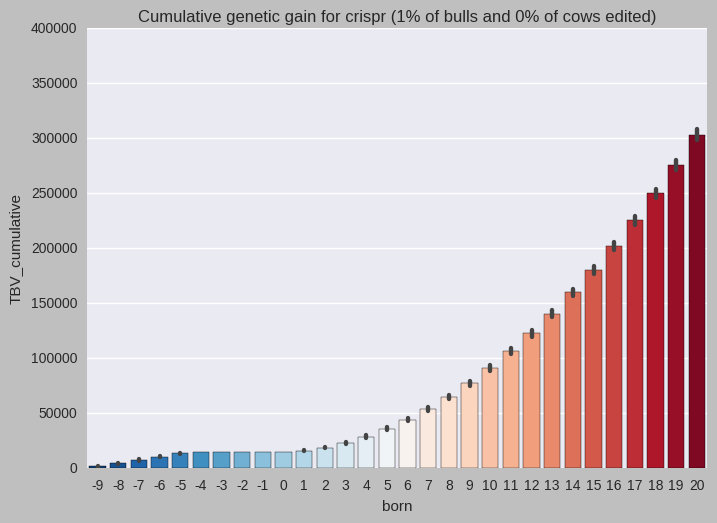

In [51]:
sns.set(style="darkgrid")
for method in grouped['method'].value_counts().keys():
    sns_plot = sns.barplot(grouped[grouped['method'] == method]['born'],
                grouped[grouped['method'] == method]['TBV_cumulative'],
                palette="RdBu_r")
    plt.ylim(0,400000)
    plt.title(method)
    sns.plt.title('Cumulative genetic gain for %s (1%% of bulls and 0%% of cows edited)'%(method))
    sns_plot.get_figure().savefig('multiple/01_00/genetic_gain_multiple_%s_01_00.png'%(method), dpi=300)
    plt.show()